# PROJET FINAL

## 1.Introduction

Dans ce projet, l’objectif est d’étudier la régulation de la glycémie (le taux de glucose dans le sang) lors d’une prise orale de glucose. Après une prise orale, le glucose est absorbé par l’intestin pour ensuite passer dans le sang. De ce fait, comparée aux modèles développés dans le TD précédent il faut rajouter un compartiment qui est celui de l’intestin. La plupart du temps ce compartiment est relativement facile à modéliser mais pas lorsqu’on s’intéresse à des maladies métaboliques impliquant l’intestin. Le test oral de tolérance au glucose est un test classique effectué pour tester la tolérance de l’organisme au glucose - et donc de détecter des diabètes.  

Dans ce projet, en utilisant ce que vous avez appris - en modélisation mais aussi en informatique - vous allez développer un modèle de prédiction de la glycémie en fonction de la dose de glucose ingérée oralement. Ce projet est en 3 parties :  

— Partie I « simple » qui s’effectuera sur un jeu de données prévu pour la calibration de votre modèle  
— Partie II « avancée » qui développera un modèle plus réaliste  
— Partie III « exploitation » qui va vous permettre de tester l’impact d’une pathologie absorptive  

Toutes les parties sont importantes il ne faut pas sauter les étapes et donc il faut effectuer les parties dans l’ordre. La première partie finalisée est le minimum vital pour avoir l’UE. Les deux autres parties servent à améliorer votre note.


## 2. Calibration du modèle

Vous allez développer un modèle de prise orale de glucose et chercher à obtenir un modèle qui fonctionne avec des paramètres réalistes. Pour cela vous aller utiliser le premier
fichier de données : full_ogtt.txt qui est un tableau dont la première colonne contient les temps de mesures en minutes. Ensuite, chaque colonne est une souris avec la glycémie
obtenu (en mg/dL). Attention : la dernière colonne correspond à la moyenne de toutes les mesures temporelles. Vous noterez que seul le glucose est dosé et donc vous n’avez pas accès à la concentration d’insuline.  

La quantité de glucose orale donnée est une dose poids qui est convertie en mg/dL envoyé à l’intestin. La dose pour le poids de la souris est donc déjà normalisée. Pour cette partie, les expériences ont été effectuées avec G0 = 4500mg/dL pour le bolus envoyé à l’intestin.

En utilisant ce que vous savez :
1. visualiser les données et détecter la phase d’absorption par l’intestin et passage dans le sang suivie de l’effet de l’insuline

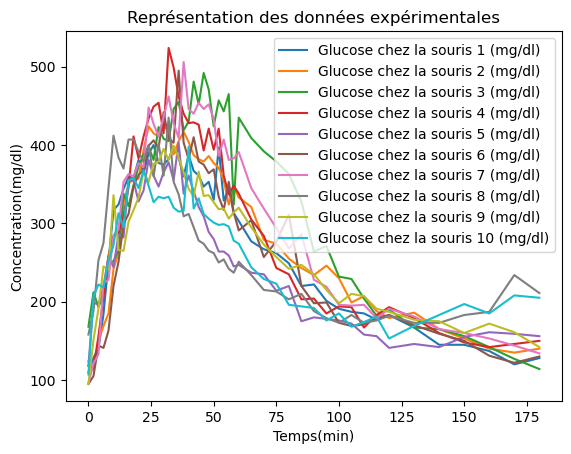

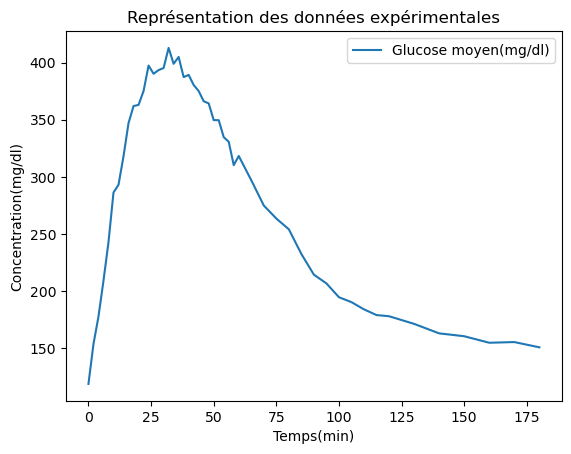

In [18]:
#Imports 

import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

#Chargement des données
data = np.loadtxt("full_ogtt.txt",dtype=float).T
nbs = data.shape[0] - 2

#Plot 
for i in range(1,nbs+1):
    plt.plot(data[0],data[i],label="Glucose chez la souris "+str(i)+" (mg/dl)")
    
plt.title("Représentation des données expérimentales")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration(mg/dl)')
plt.legend()
plt.show()

plt.plot(data[0],data[nbs+1],label="Glucose moyen(mg/dl)")
plt.title("Représentation des données expérimentales")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration(mg/dl)')
plt.legend()
plt.show()

La phase d'absorption par l'intestin, si on se rapporte à la courbe du glucose moyen, se situe entre le début des données jusqu'au pic de glucose, puis apres le pic survient le "pseudo-pic" d'insuline qui réduit le taux de glucose.

2. en supposant que le bolus de glucose arrive instantanément à t = 0 dans l’intestin,écrire l’équation modélisant le transfert de glucose intestinal (simple) à vitesse constante  

Remarque : il y aura donc un glucose intestinal et un glucose sanguin

Si l'on considère Gi comme glucose intestinal et Gs glucose sanguin sans prendre en compte l'insuline, on obtient comme équation :  
- Gi(t) = - a * Gi(t)
- Gs(t) = a * Gi(t)    

3. réutiliser les équations des modèles des TDs précédents pour les concentrations sanguines (pour l’insuline et le glucose).

Les équations pour les concentrations sanguines uniquement de glucose et insuline sont :  
- Gs(t) = - b * I(t) * Gs(t) - c * max(0,Gs(t)-Gb)
- I(t) = d * (Gs(t) ** n)- e * I

4. écrire le système d’équations différentielles ; combien a-t-on de paramètres libres ?

In [19]:
#Modèle 

def in_model(y,t,a,b,c,d,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    dgidt = -a*Gi
    dgsdt = a*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*(Gs**2)-e*I
    return dgidt,dgsdt,didt


Les paramètres libres sont : a,b,c,d,e,n.

5. essayer d’obtenir d’une courbe typique, il faudra utiliser la valeur de G0 , et les mesures pour le choix de conditions initiales.

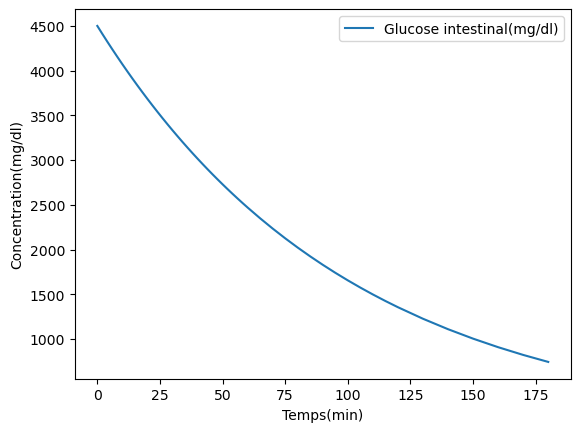

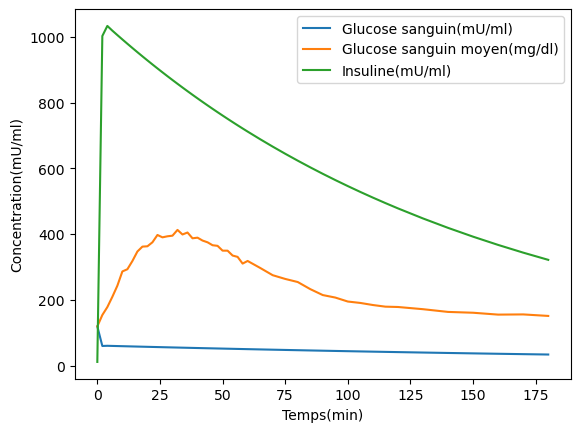

In [20]:
#Paramètres
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.0065
b= 1e-4
c= 0.05
d= 2
e= 5

"""
a = 3e-3
b= 1e-4
c= 0.05
d= 1
e= 4
"""
a= 1e-2
b= 6e-4
c= 3e-3
d= 0.005
e = 5
n = 2

#ihsan
a=1e-2
b=7e-4
c=6e-2
d=1
e= 3.5

P = odeint(in_model,y0,t,args=(a,b,c,d,e)).T
plt.plot(t,P[0],label="Glucose intestinal(mg/dl)")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration(mg/dl)')
plt.legend()
plt.show()

plt.plot(t,P[1],label="Glucose sanguin(mU/ml)")
plt.plot(data[0],data[nbs+1],label="Glucose sanguin moyen(mg/dl)")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration(mg/dl)')


plt.plot(t,P[2],label="Insuline(mU/ml)")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration(mU/ml)')
plt.legend()
plt.show()

6. en minimisant une distance, trouver un jeu de paramètres qui permet de reproduire les données pour chaque souris : présenter et commenter vos résultats.

In [21]:
#Fonction de distance

def distance_n(param,obs,t,y0):
    a,b,c,d,e= param
    P = odeint(in_model,y0,t,args=(a,b,c,d,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(a<0) + 1e8*(b<0) +1e8*(c<0)+1e8*(d<0) + 1e8*(e<0) 



In [22]:
#Paramètres
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
b= 8e-11
c= 0.12
d= 1.5
e= 5.1
#n = 2.17

a = 3e-3
b= 1e-4
c= 0.05
d= 1
e= 4

a= 9e-3
b= 7e-11
c= 1e-1
d= 1e1
e = 2.5

#iter 1
a= 1e-2
b= 6e-4
c= 3e-3
d= 0.005
e = 5
n = 2.3

#it2
a= 9e-2
b= 6e-4
c= 3e-3
d= 0.005
e = 5
n = 2.3

#ihsan
a=1e-2
b=7e-4
c=6e-2
d=1
e= 3.5

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 60427.245659
         Iterations: 413
         Function evaluations: 705
[9.42927889e-03 7.69716452e-04 1.24647412e-01 8.55372343e-12
 2.68032075e+00]


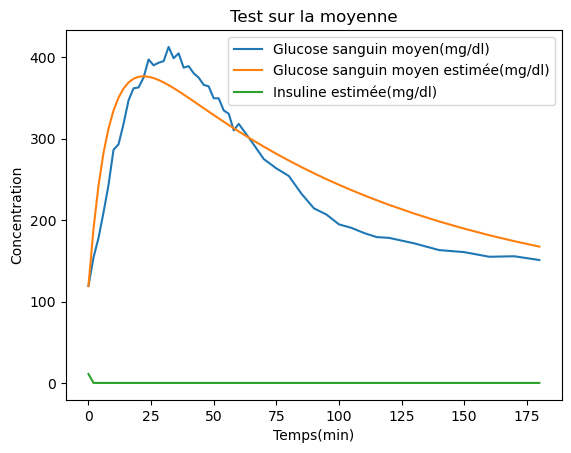

In [23]:
#Test sur moyenne
#Paramètres
param_n = [a,b,c,d,e]

#estimationvdes paramètres
#P = odeint(in_model,y0,t,args=(a,b,c,d,e,n)).T

p= fmin(distance_n,param_n,args=(data[11],t,y0))
print(p)

PestimM = odeint(in_model,y0,t,args=(p[0],p[1],p[2],p[3],p[4])).T

plt.plot(t,data[11],label="Glucose sanguin moyen(mg/dl)")
plt.plot(t,PestimM[1],label="Glucose sanguin moyen estimée(mg/dl)")
#plt.plot(t,P[2],label="Insuline mg/dl)")
plt.plot(t,PestimM[2],label="Insuline estimée(mg/dl)")


plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.title("Test sur la moyenne")
plt.legend()
plt.show()

[9.97242897e-03 6.91567251e-04 1.32164455e-01 1.36630502e-10
 2.80894102e+00]


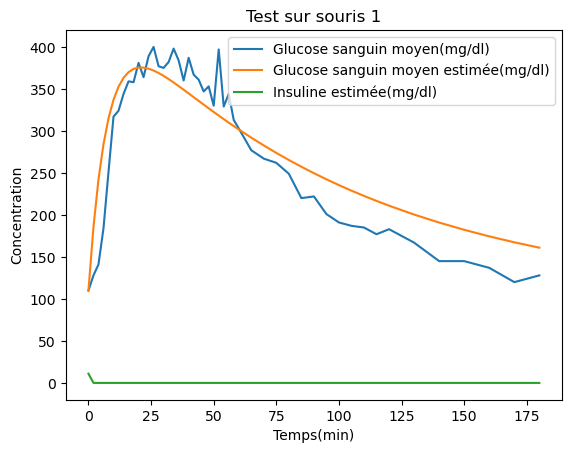

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[8.48386012e-03 9.20661990e-04 1.11140936e-01 6.69375139e-11
 3.05754156e+00]


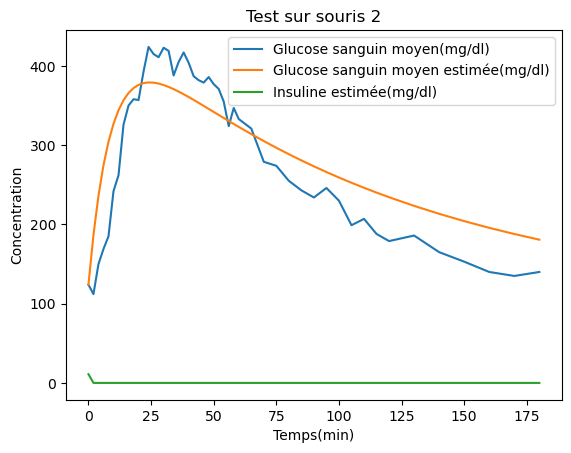

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 189633.256191
         Iterations: 477
         Function evaluations: 965
[7.89479313e-03 2.09729341e-15 9.04886481e-02 1.53900275e+00
 3.32742790e+00]


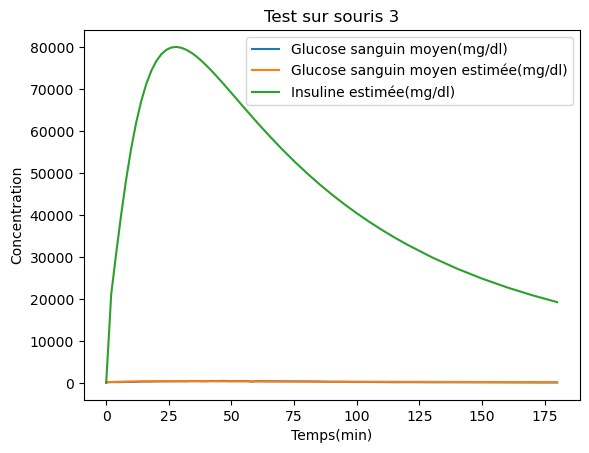

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 159338.773091
         Iterations: 322
         Function evaluations: 579
[1.02875353e-02 6.87522003e-04 1.16413119e-01 1.19563635e-10
 3.21327305e+00]


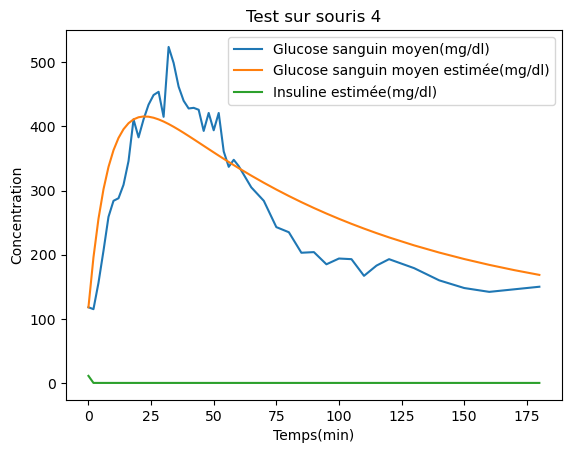

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 63588.247085
         Iterations: 482
         Function evaluations: 817
[1.06707428e-02 9.89520082e-17 1.63943875e-01 1.59633276e-01
 1.72918584e+00]


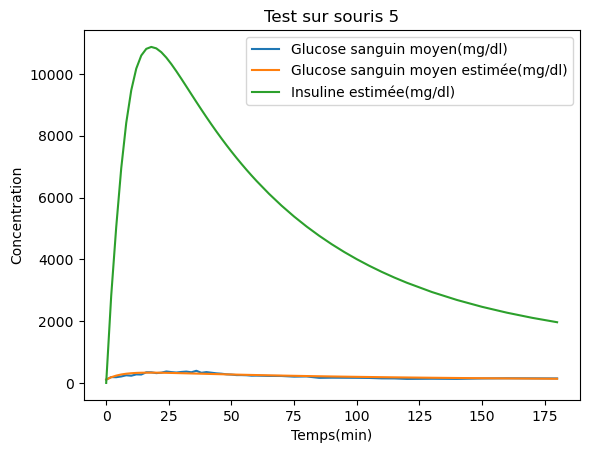

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[8.71038219e-03 6.13198398e-03 1.17835016e-01 2.07944345e-11
 2.07066775e+01]


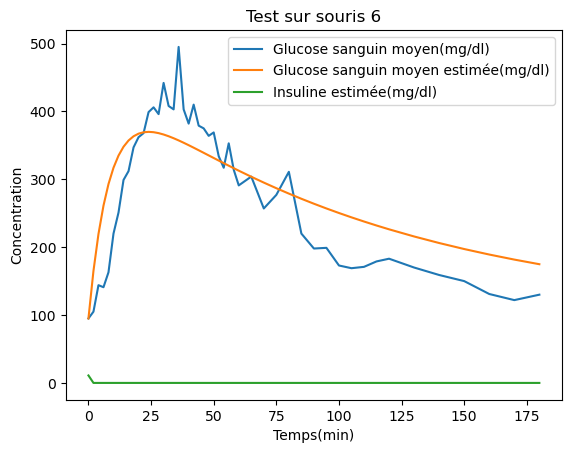

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 129146.525681
         Iterations: 365
         Function evaluations: 646
[9.45857496e-03 1.49332871e-03 1.05058319e-01 1.30174579e-10
 4.79590051e+00]


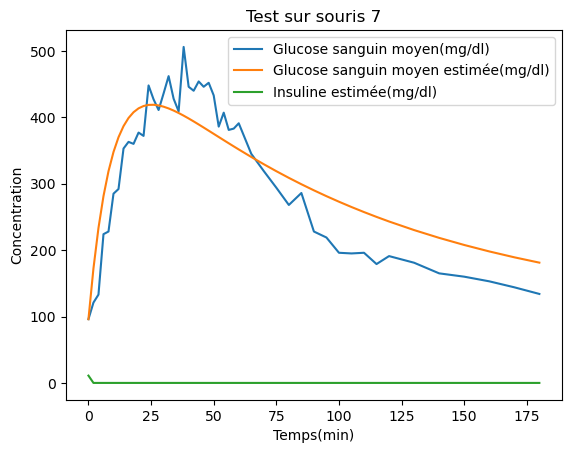

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.36000673e-02 2.46118928e-13 1.77609904e-01 4.31353349e-02
 2.17069408e+00]


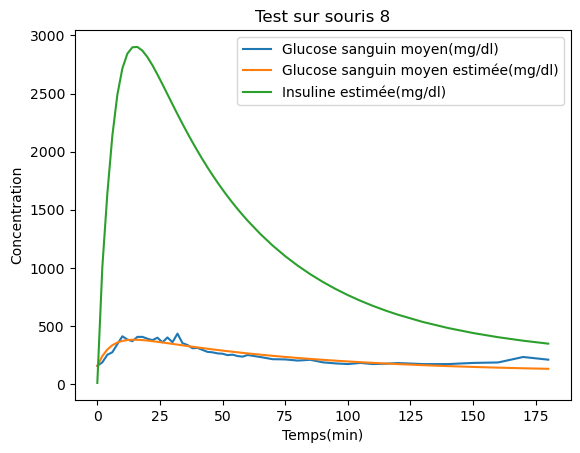

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[8.82722281e-03 2.59875824e-03 1.26698532e-01 1.34622538e-10
 1.16663697e+01]


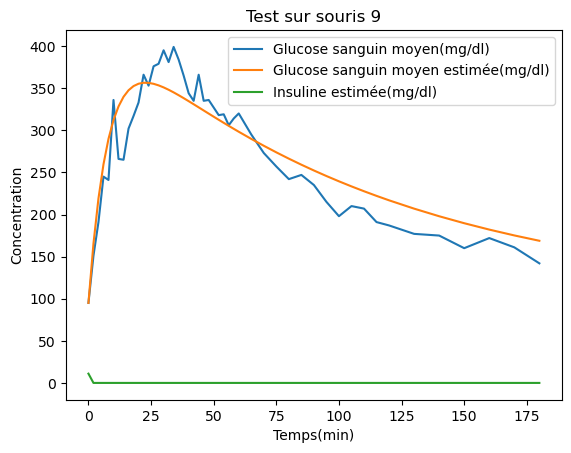

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 42674.113614
         Iterations: 331
         Function evaluations: 577
[9.71203023e-03 5.64629275e-04 1.51575150e-01 3.69695738e-12
 1.07055165e+00]


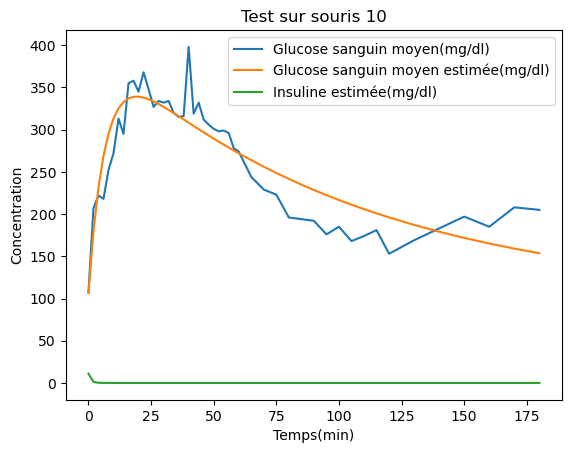

In [25]:
#Test sur souris

#estimation des paramètres puis affichage
for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_n,param_n,args=(data[i],t,y0))
    print(p)

    P = odeint(in_model,y0,t,args=(a,b,c,d,e)).T
    Pestim = odeint(in_model,y0,t,args=(p[0],p[1],p[2],p[3],p[4])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    #plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

## 3. Modèle avancé

Normalement le modèle à compartiments simples a du mal à fonctionner : est-ce le cas chez vous ? Le modèle précédent suppose une absorption constante et donc un nombre constant de transporteurs du glucose dans l’intestin. Mais le bolus de glucose chemine le long de l’axe intestinal au cours du temps et la densité de transporteurs va diminuer : l’absorption au cours du temps devrait donc diminuer.  

Nous allons introduire une modification au modèle pour prendre en compte ce processus :  

— soit U la vitesse absorption : le glucose intestinal va quitter le compartiment intestinal à la vitesse U ∗ Gi ou Gi désigne le glucose intestinal  

— Nous supposerons que la quantité de transporteurs diminue exponentiellement. Si lebolus parcours l’axe gastrointestinal à vitesse constante alors la vitesse de transport dans le sang va diminuer également de façon exponentielle : dU/dt = −kU.  

— La vitesse d’absorption à la sortie de l’estomac et l’entrée de l’intestin est inconnue (donc à déterminer), elle correspond à la vitesse initiale U0.  


1. Adapter vos équations avec ces nouvelles informations.

In [26]:
def av_model(y,t,U0,k,b,c,d,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*(Gs**2)-e*I
    return dgidt,dgsdt,didt

2. Relancer la recherche de paramètres par minimisation sur le même jeu de données full_ogtt.txt (attention il n’y a pas forcément le même nombre de paramètres que dans la Partie I)

In [27]:
#Paramètres
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = 8e-1
k = 1e-2
b= 8e-11
c= 0.12
d= 1.5
e= 5.1

a= 1e-2
b= 6e-4
c= 3e-3
d= 0.005
e = 5


#Fonction de distance

def distance_av(param,obs,t,y0):
    U0,k,b,c,d,e= param
    P = odeint(av_model,y0,t,args=(U0,k,b,c,d,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(U0<0)+ 1e8*(k<0) + 1e8*(b<0) +1e8*(c<0)+1e8*(d<0) + 1e8*(e<0)



Optimization terminated successfully.
         Current function value: 544701.309029
         Iterations: 666
         Function evaluations: 1095
[1.29550941e-03 1.20831411e-02 1.06293891e-19 1.29505261e-02
 9.78256837e-01 6.19205020e-02]


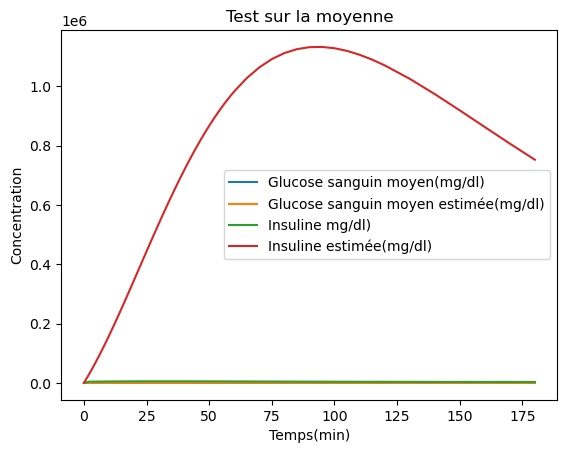

In [28]:
#Test sur moyenne
U0 = 3
k= 2e-6
b= 5e-4
c= 2e-4
d= 7e-4
e = 2

U0 = 5e-4
k= 2e-2
b= 7e-10
c= 3e-2
d= 1
e = 3.5

#Paramètres
param_n = [U0,k,b,c,d,e]

#estimation des paramètres
P = odeint(av_model,y0,t,args=(U0,k,b,c,d,e)).T

p= fmin(distance_av,param_n,args=(data[11],t,y0))
print(p)

PestimM = odeint(av_model,y0,t,args=(p[0],p[1],p[2],p[3],p[4],p[5])).T

plt.plot(t,data[11],label="Glucose sanguin moyen(mg/dl)")
plt.plot(t,PestimM[1],label="Glucose sanguin moyen estimée(mg/dl)")
plt.plot(t,P[2],label="Insuline mg/dl)")
plt.plot(t,PestimM[2],label="Insuline estimée(mg/dl)")


plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.title("Test sur la moyenne")
plt.legend()
plt.show()


In [ ]:
#Test sur souris
arr = np.zeros((10,6))

#estimation des paramètres puis affichage
for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av,param_n,args=(data[i],t,y0))
    print(p)
    
    arr[i-1] = p
    
    P = odeint(av_model,y0,t,args=(U0,k,b,c,d,e)).T
    Pestim = odeint(av_model,y0,t,args=(p[0],p[1],p[2],p[3],p[4],p[5])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

In [12]:
U0m = [arr[:,0].mean(),arr[:,0].std()]
km = [arr[:,1].mean(),arr[:,1].std()]
bm = [arr[:,2].mean(),arr[:,2].std()]
cm = [arr[:,3].mean(),arr[:,3].std()]
dm = [arr[:,4].mean(),arr[:,4].std()]
em = [arr[:,5].mean(),arr[:,5].std()]

params_moy = [U0m[0],km[0],bm[0],cm[0],dm[0],em[0]]
params_std = [U0m[1],km[1],bm[1],cm[1],dm[1],em[1]]

print(params_moy)
print(params_std)

[0.006395163541163797, 0.02054214693120841, 8.37017589312468e-11, 0.05256675253550021, 2.287577520141888, 4.5651175936690205]
[0.001728820882367194, 0.007336583959716442, 5.0488627082802564e-11, 0.03156875079599054, 3.198802149441183, 3.1365805093870054]


[5.85641758e-03 2.02218056e-02 8.90295674e-11 4.34309565e-02
 2.41158480e+00 4.84912149e+00]


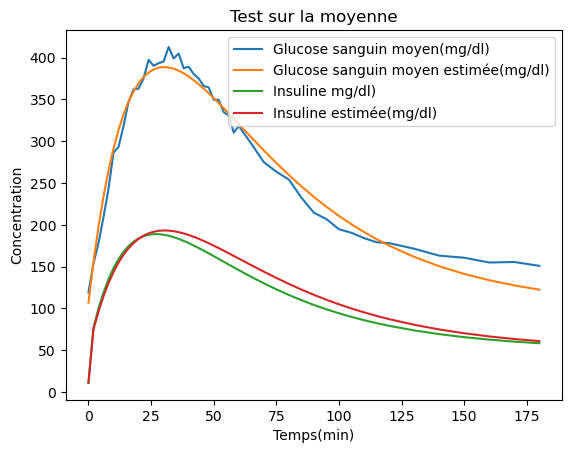

In [13]:
#estimation des paramètres

P = odeint(av_model,y0,t,args=(params_moy[0],params_moy[1],params_moy[2],params_moy[3],params_moy[4],params_moy[5])).T

p= fmin(distance_av,params_moy,args=(data[11],t,y0))
print(p)

PestimM = odeint(av_model,y0,t,args=(p[0],p[1],p[2],p[3],p[4],p[5])).T

plt.plot(t,data[11],label="Glucose sanguin moyen(mg/dl)")
plt.plot(t,PestimM[1],label="Glucose sanguin moyen estimée(mg/dl)")
plt.plot(t,P[2],label="Insuline mg/dl)")
plt.plot(t,PestimM[2],label="Insuline estimée(mg/dl)")


plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.title("Test sur la moyenne")
plt.legend()
plt.show()

[5.80268015e-03 2.33292920e-02 9.31597382e-11 4.04437287e-02
 2.32561664e+00 4.93302168e+00]


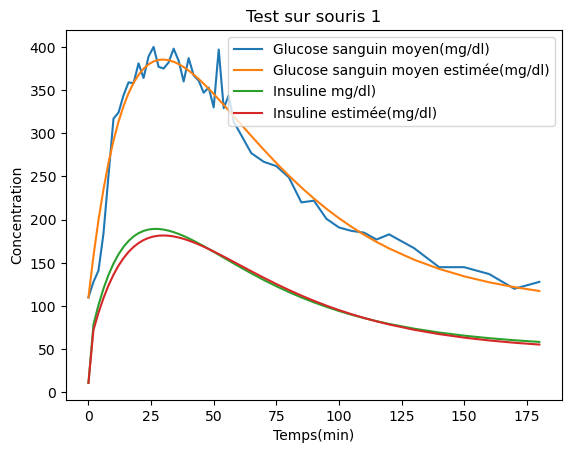

Optimization terminated successfully.
         Current function value: 32015.809693
         Iterations: 151
         Function evaluations: 281
[5.09793539e-03 2.66524451e-02 1.02146962e-10 2.89996918e-02
 2.59157069e+00 4.48380813e+00]


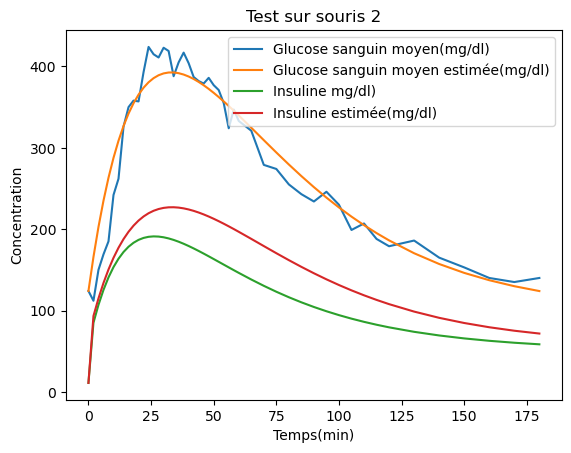

Optimization terminated successfully.
         Current function value: 71775.841528
         Iterations: 227
         Function evaluations: 486
[4.67342041e-03 2.39218308e-02 9.50121630e-11 2.40478678e-02
 2.93811956e+00 6.26021793e+00]


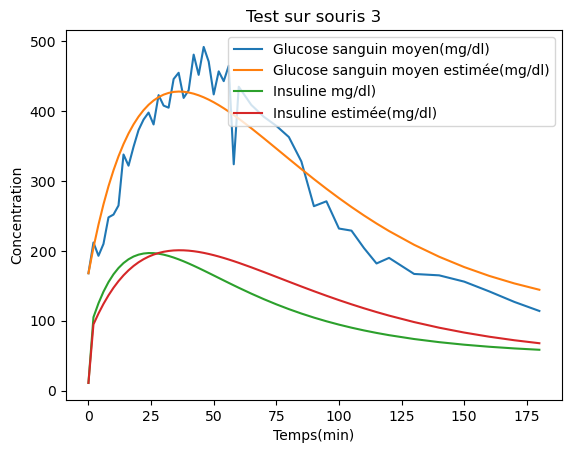

Optimization terminated successfully.
         Current function value: 59138.625176
         Iterations: 164
         Function evaluations: 293
[6.48896780e-03 3.01421789e-02 3.25204129e-11 3.18493624e-02
 3.55792485e+00 3.18078666e+00]


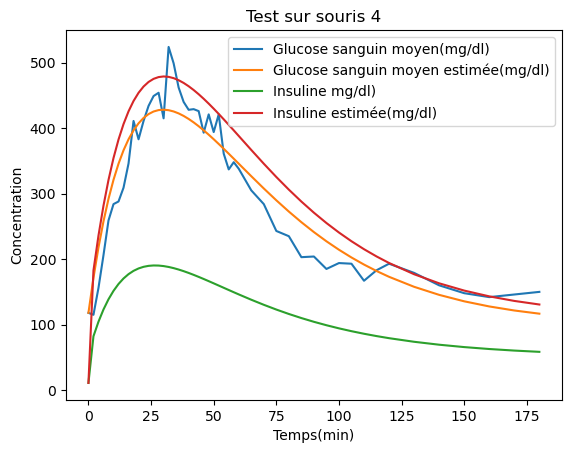

Optimization terminated successfully.
         Current function value: 25707.640548
         Iterations: 165
         Function evaluations: 287
[5.97501348e-03 2.02541955e-02 7.48905444e-11 5.67968139e-02
 2.54346797e+00 4.68981959e+00]


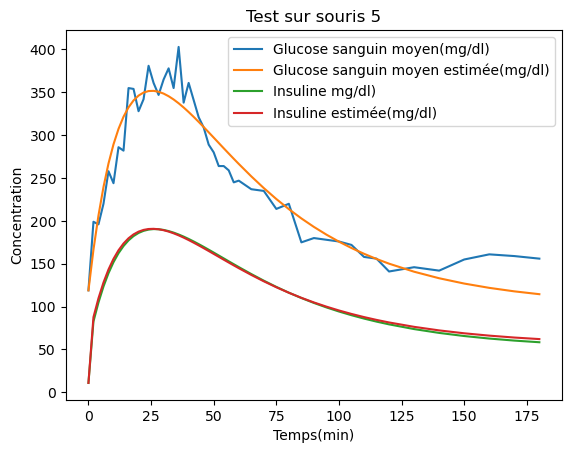

Optimization terminated successfully.
         Current function value: 55615.176714
         Iterations: 173
         Function evaluations: 299
[5.53501610e-03 2.90093683e-02 3.45418523e-11 3.04381932e-02
 1.76332060e+00 5.94166202e+00]


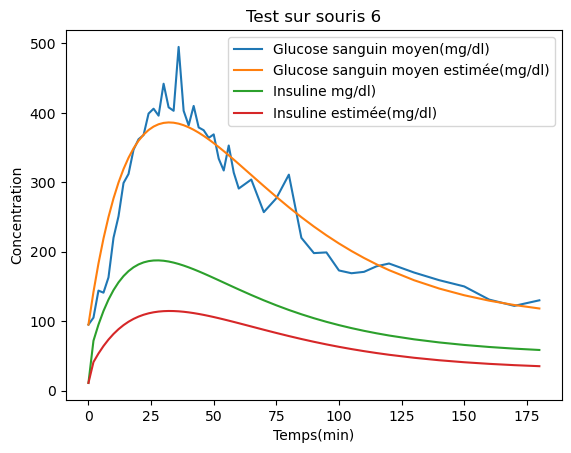

Optimization terminated successfully.
         Current function value: 34892.119103
         Iterations: 152
         Function evaluations: 266
[6.25094242e-03 2.80957602e-02 4.51676793e-11 2.91364632e-02
 2.83114558e+00 5.04607035e+00]


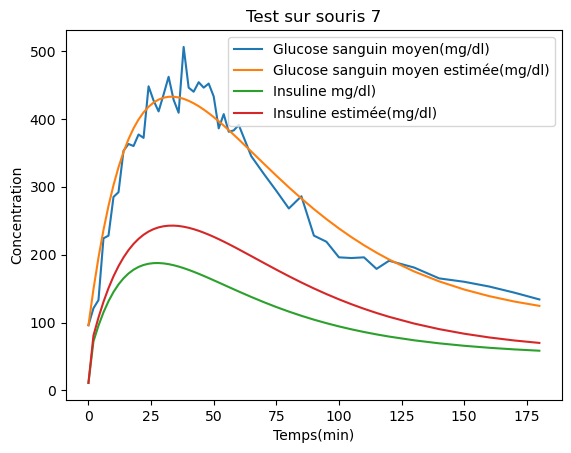

Optimization terminated successfully.
         Current function value: 46064.622896
         Iterations: 157
         Function evaluations: 291
[1.12112326e-02 8.44696931e-03 2.30841871e-11 1.28769946e-01
 1.18826258e+00 3.66947611e+00]


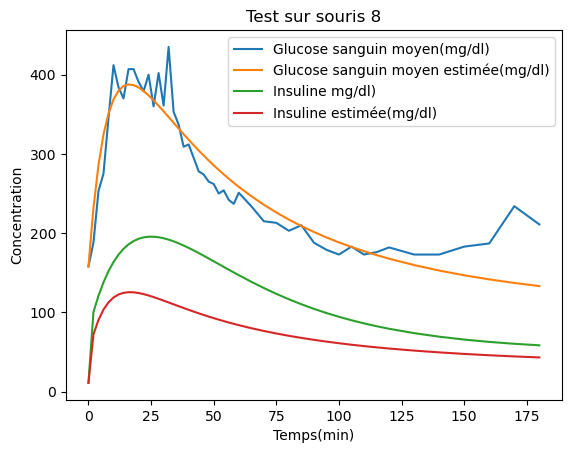

Optimization terminated successfully.
         Current function value: 16032.852142
         Iterations: 230
         Function evaluations: 490
[5.83299487e-03 1.31293555e-02 6.72494699e-11 5.78891996e-02
 2.66277563e+00 5.43279385e+00]


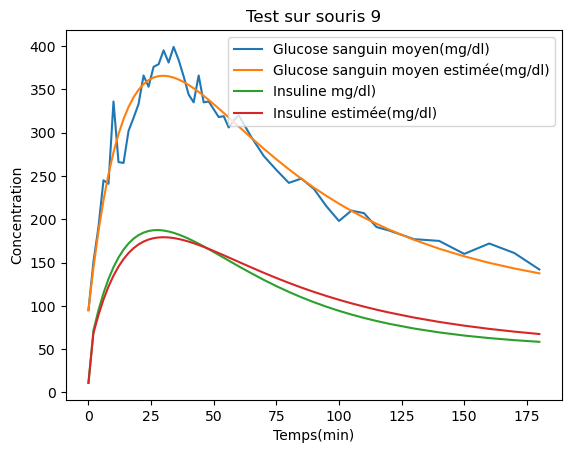

Optimization terminated successfully.
         Current function value: 32540.307174
         Iterations: 434
         Function evaluations: 738
[6.82876921e-03 9.97677550e-03 1.97861872e-17 8.51555646e-02
 1.27205437e-05 5.58548243e+00]


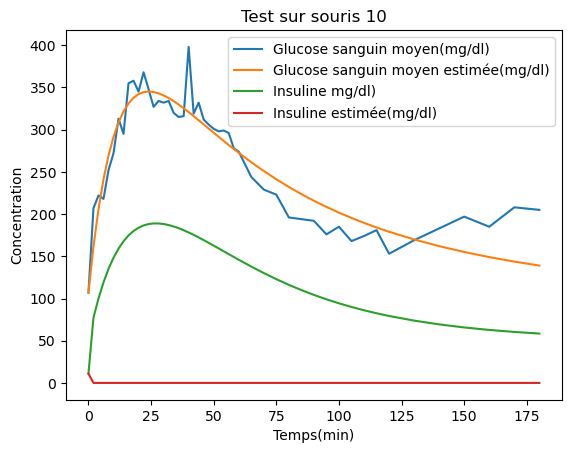

In [14]:
#estimation des paramètres puis affichage

arr2 = np.zeros((10,6))

for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av,params_moy,args=(data[i],t,y0))
    print(p)
    
    arr2[i-1] = p
    
    P = odeint(av_model,y0,t,args=(params_moy[0],params_moy[1],params_moy[2],params_moy[3],params_moy[4],params_moy[5])).T
    Pestim = odeint(av_model,y0,t,args=(p[0],p[1],p[2],p[3],p[4],p[5])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

3. Discuter de l’amélioration de votre modèle et éventuellement des résultats biologiques : notamment on a donné 4500mg/dl de glucose en oral au souris, vont-elles tout absorber ?

In [15]:
U0m2 = [arr2[:,0].mean(),arr2[:,0].std()]
km2 = [arr2[:,1].mean(),arr2[:,1].std()]
bm2 = [arr2[:,2].mean(),arr2[:,2].std()]
cm2 = [arr2[:,3].mean(),arr2[:,3].std()]
dm2 = [arr2[:,4].mean(),arr2[:,4].std()]
em2 = [arr2[:,5].mean(),arr2[:,5].std()]

params_moy2 = [U0m2[0],km2[0],bm2[0],cm2[0],dm2[0],em2[0]]
params_std2 = [U0m2[1],km2[1],bm2[1],cm2[1],dm2[1],em2[1]]

for i in range(len(params_moy)):
    print("v"+str(i)+" reso_1 : "+str(params_moy[i])+" et ect reso_1 :"+str(params_std[i]))
    print("v"+str(i)+" reso_2 : "+str(params_moy2[i])+" et ect reso_2 :"+str(params_std2[i]))

v0 reso_1 : 0.006395163541163797 et ect reso_1 :0.001728820882367194
v0 reso_2 : 0.006369697239719739 et ect reso_2 :0.001721519638837271
v1 reso_1 : 0.02054214693120841 et ect reso_1 :0.007336583959716442
v1 reso_2 : 0.02129581711597654 et ect reso_2 :0.007646635272693875
v2 reso_1 : 8.37017589312468e-11 et ect reso_1 :5.0488627082802564e-11
v2 reso_2 : 5.677730293876594e-11 et ect reso_2 :3.2951827259321744e-11
v3 reso_1 : 0.05256675253550021 et ect reso_1 :0.03156875079599054
v3 reso_2 : 0.05135268309197357 et ect reso_2 :0.03143883307440053
v4 reso_1 : 2.287577520141888 et ect reso_1 :3.198802149441183
v4 reso_2 : 2.240221682875503 et ect reso_2 :0.9657345134533679
v5 reso_1 : 4.5651175936690205 et ect reso_1 :3.1365805093870054
v5 reso_2 : 4.922313874841658 et ect reso_2 :0.9161730720373619


Le nombre de paramètres inconnus peut être important, et donc le problème de recherche certains de ces paramètres peuvent être sur-déterminés (i.e ces paramètres sont dépendants et plusieurs autres valeurs de jeux de paramètres donnent la même sortie du modèle). Ainsi il faut essayer de réduire le nombre les paramètres. Une option est de fixer un(des) paramètre(s) (il ne sont plus estimés) puis de vérifier si on arrive encore à ajuster les données avec le modèle. Si c’est le cas alors ce paramètre peut rester fixe - il est sur-déterminé ou la sortie du modèle n’est pas sensible à ce paramètre.

Ne pas hésiter à tester des modèles (et à faire varier les paramètres de départ pour votre minimisation). Il faut essayer d’en trouver un, le plus simple, ayant un nombre minimal de paramètres libres (normalement 4 c’est optimal). Enfin, il n’y a que le glucose donc l’information sur l’insuline ne pourra pas être obtenue. Servez vous de cela pour limiter le nombre de paramètres sur la dynamique de l’insuline.

Répéter l’approche précédente en essayant de fournir un modèle qui n’est pas (trop) sur-déterminé. C’est sur ce dernier modèle final que vous ferez le rapport - (mais vous aurez fait plein de tests/codes avant !). Vous présenterez votre méthode pour aboutir au modèle final avec vos différents tests et vos conclusions. Nous attendons des figures de fit pour chaque souris, mais aussi vos commentaires/remarques sur les paramètres estimés.

In [16]:
#Si on choisit entre U0  et k, il faudrait voir et supposer que 
#les souris ont soit une vitesse d'absorption initiale identique 
#ou une vitesse de transport sanguin (sortie) identique

#Faire la fixation  des paramètres un par un 

Optimization terminated successfully.
         Current function value: 17503.152001
         Iterations: 418
         Function evaluations: 863
[1.86946822e-02 5.25220424e-11 5.12077957e-02 6.56051063e+00
 7.89804919e-03]


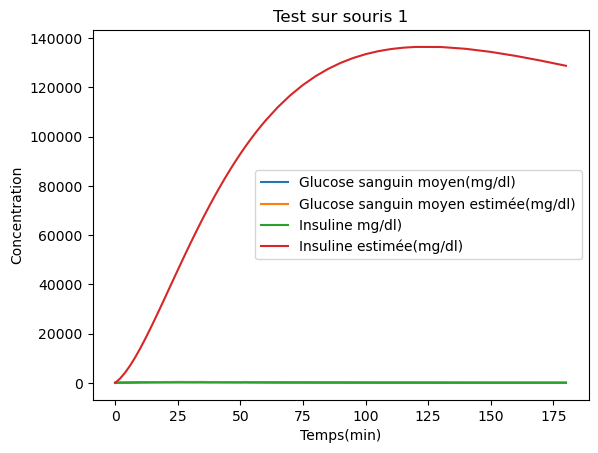

[1.53463746e-02 1.23921173e-10 5.24372439e-02 1.36041975e+00
 2.45652224e+00]


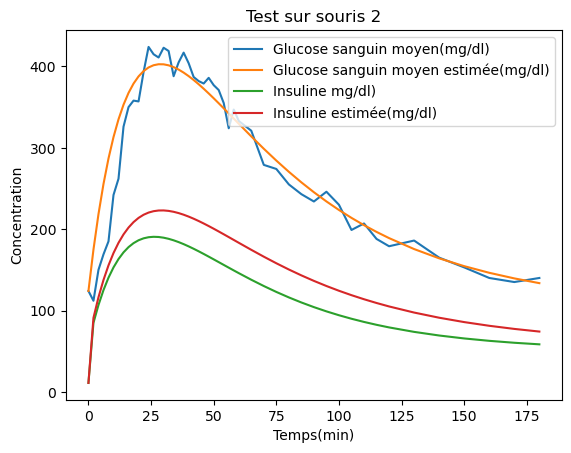

Optimization terminated successfully.
         Current function value: 115608.333584
         Iterations: 133
         Function evaluations: 250
[1.41135941e-02 8.23694855e-11 4.58204179e-02 2.01131297e+00
 5.03351210e+00]


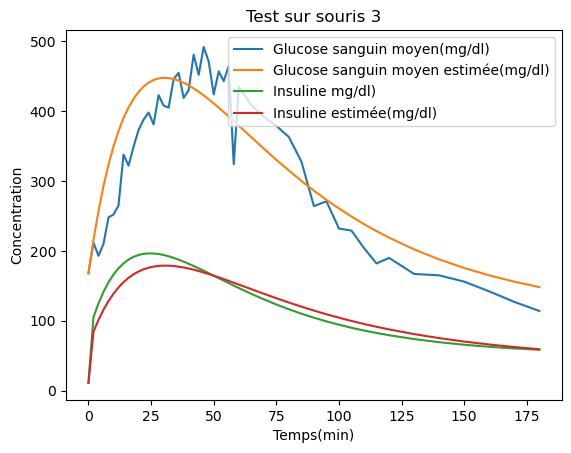

C:\Anaconda3_2022.05\envs\py3-9-13\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimization terminated successfully.
         Current function value: 59326.061678
         Iterations: 181
         Function evaluations: 314
[2.99602511e-02 8.79252569e-11 3.13906847e-02 2.33817649e+00
 4.06694774e-01]


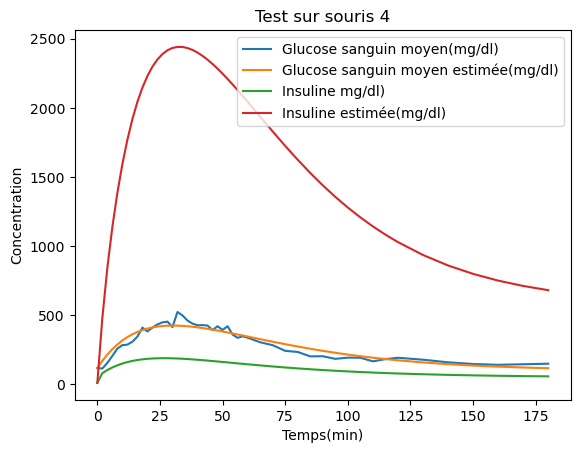

Optimization terminated successfully.
         Current function value: 26221.239842
         Iterations: 126
         Function evaluations: 224
[1.83366642e-02 7.82713380e-11 6.37012889e-02 1.11529706e+00
 3.52523321e+00]


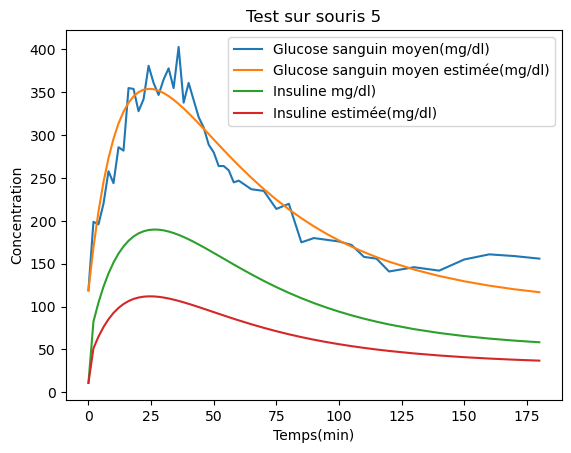

Optimization terminated successfully.
         Current function value: 65350.241105
         Iterations: 442
         Function evaluations: 771
[2.12693000e-02 1.38774685e-14 4.48441911e-02 6.05074669e-08
 1.12772251e+00]


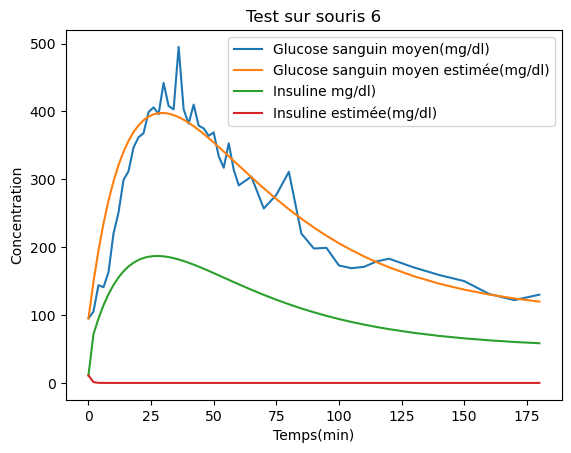

Optimization terminated successfully.
         Current function value: 35117.454803
         Iterations: 308
         Function evaluations: 690
[2.86635029e-02 1.99145640e-11 2.92298288e-02 4.58116611e-01
 1.95679563e+00]


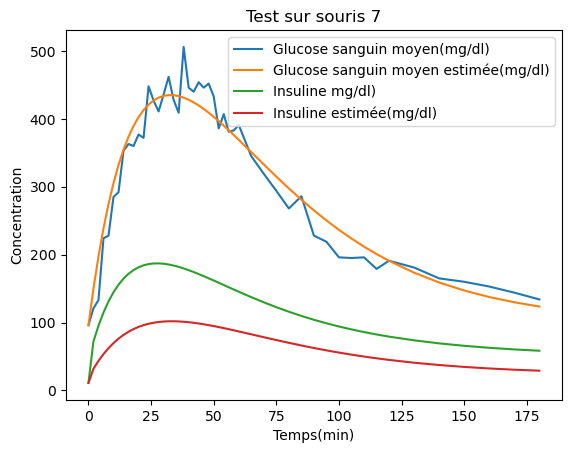

Optimization terminated successfully.
         Current function value: 77841.196661
         Iterations: 133
         Function evaluations: 267
[1.66444089e-02 1.56964546e-10 6.65062209e-02 9.22579136e-01
 3.30418841e-01]


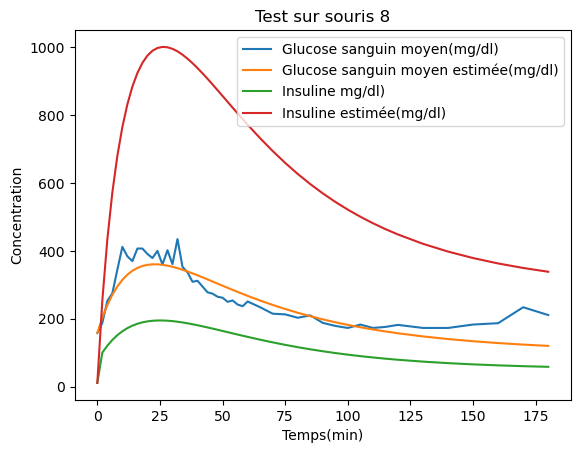

[1.13541872e-02 9.18534811e-11 6.67672698e-02 1.52464907e+00
 5.31285511e+00]


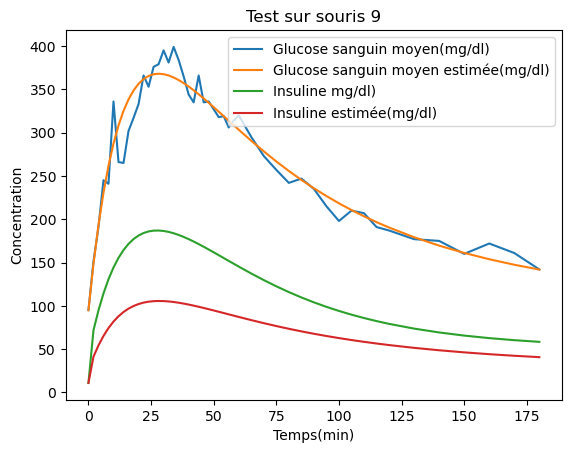

Optimization terminated successfully.
         Current function value: 33447.156805
         Iterations: 173
         Function evaluations: 381
[1.07944210e-02 8.89679521e-11 7.82260878e-02 1.64859797e+00
 5.81195427e+00]


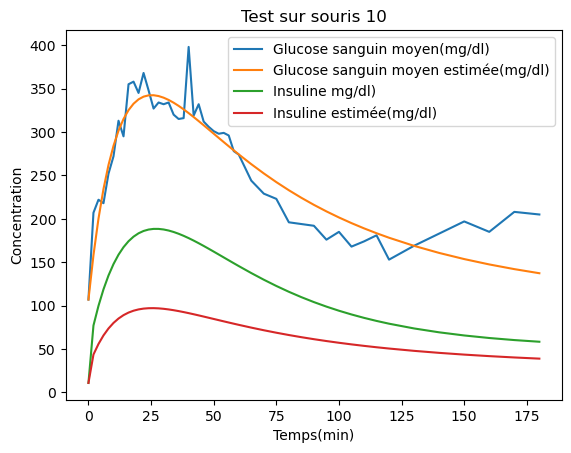

In [17]:
#Ici  on va tester la fixation de U0 : donc on suppose une vitesse d'absorption initiale identique chez la souris
#Paramètres
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = params_moy2[0]
k = 1e-2
b= 8e-11
c= 0.12
d= 1.5
e= 5.1

para = [k,b,c,d,e]

def av_model_u0_fix(y,t,k,b,c,d,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    U0 = params_moy2[0]
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*Gs-e*I
    return dgidt,dgsdt,didt

def distance_av_u0_fix(param,obs,t,y0):
    k,b,c,d,e= param
    P = odeint(av_model_u0_fix,y0,t,args=(k,b,c,d,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(k<0) + 1e8*(b<0) +1e8*(c<0)+1e8*(d<0) + 1e8*(e<0)


for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av_u0_fix,para,args=(data[i],t,y0))
    print(p)
    
    P = odeint(av_model_u0_fix,y0,t,args=(params_moy[1],params_moy[2],params_moy[3],params_moy[4],params_moy[5])).T
    Pestim = odeint(av_model_u0_fix,y0,t,args=(p[0],p[1],p[2],p[3],p[4])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

Optimization terminated successfully.
         Current function value: 16000.346430
         Iterations: 123
         Function evaluations: 237
[5.88296960e-03 1.02349593e-10 4.36683235e-02 1.22583159e+00
 7.05029064e+00]


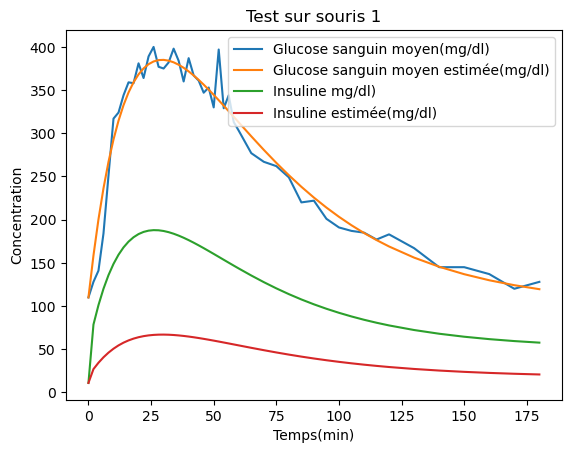

Optimization terminated successfully.
         Current function value: 32617.673180
         Iterations: 123
         Function evaluations: 225
[5.17642091e-03 9.65364291e-11 3.50622822e-02 1.41329363e+00
 5.26360666e+00]


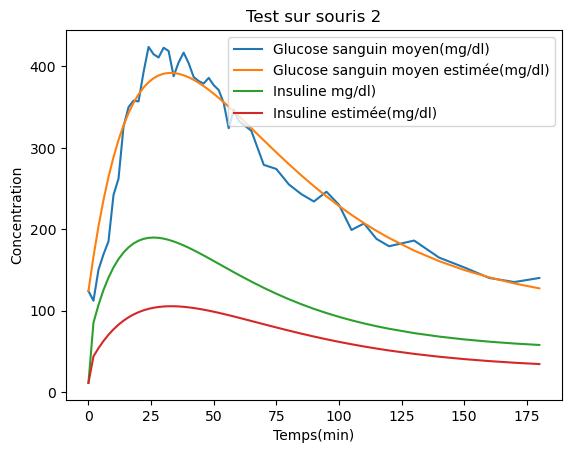

[4.68551102e-03 1.01188132e-10 2.63509087e-02 2.47623672e+00
 4.61709553e+00]


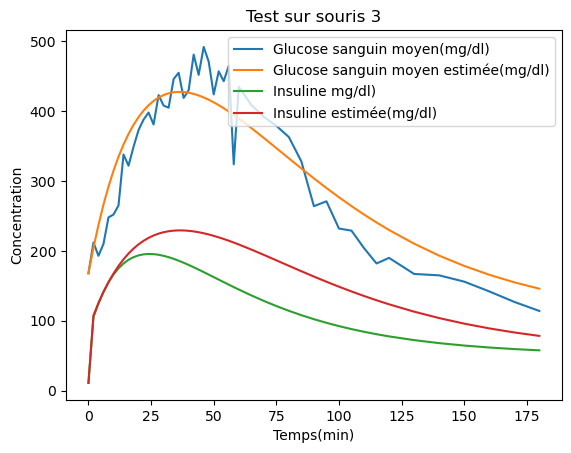

Optimization terminated successfully.
         Current function value: 62297.595241
         Iterations: 122
         Function evaluations: 253
[6.60739253e-03 8.90957008e-11 4.19959624e-02 1.39751170e+00
 8.61874648e+00]


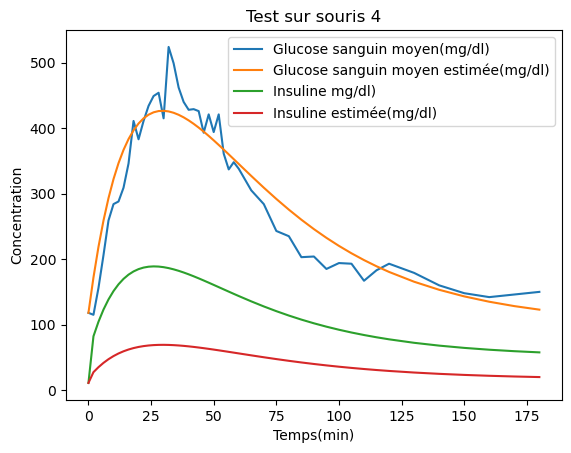

[5.91120705e-03 6.83525633e-11 5.45808094e-02 2.09247803e+00
 8.38116984e+00]


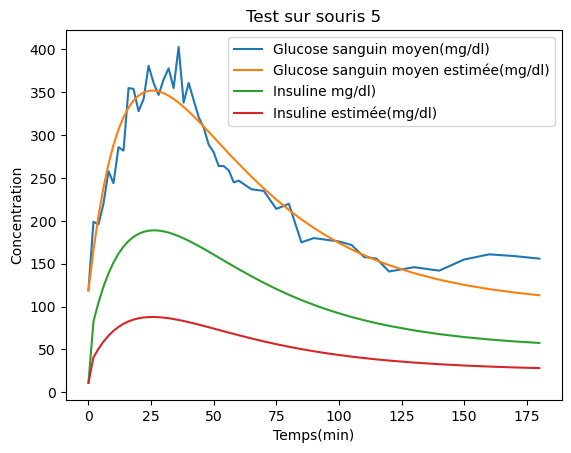

[5.57325298e-03 9.17082416e-11 3.91327081e-02 2.46040058e+00
 5.94041511e+00]


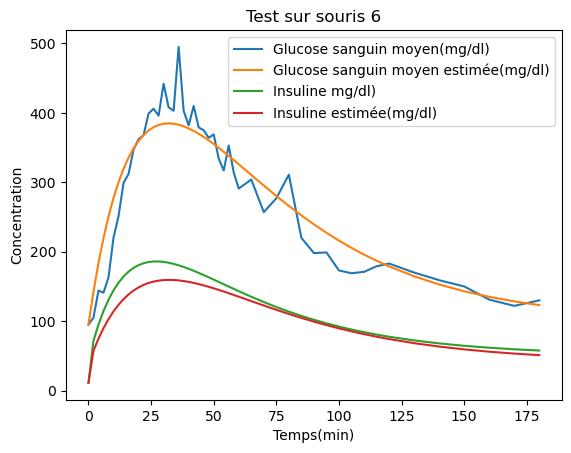

Optimization terminated successfully.
         Current function value: 36843.559864
         Iterations: 111
         Function evaluations: 201
[6.28397769e-03 1.29820765e-10 3.64495920e-02 2.05926185e+00
 6.64644030e+00]


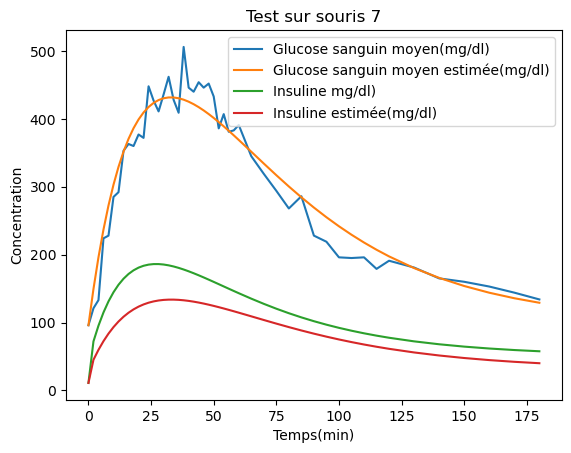

Optimization terminated successfully.
         Current function value: 63475.771053
         Iterations: 112
         Function evaluations: 204
[8.83396615e-03 8.88227053e-11 7.88565696e-02 1.69518171e+00
 6.43973449e+00]


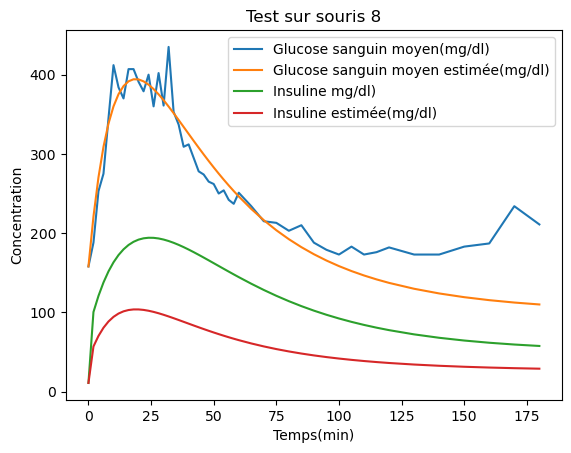

Optimization terminated successfully.
         Current function value: 19855.536357
         Iterations: 106
         Function evaluations: 190
[5.27897544e-03 1.07689318e-10 3.96898976e-02 2.56023678e+00
 3.62345778e+00]


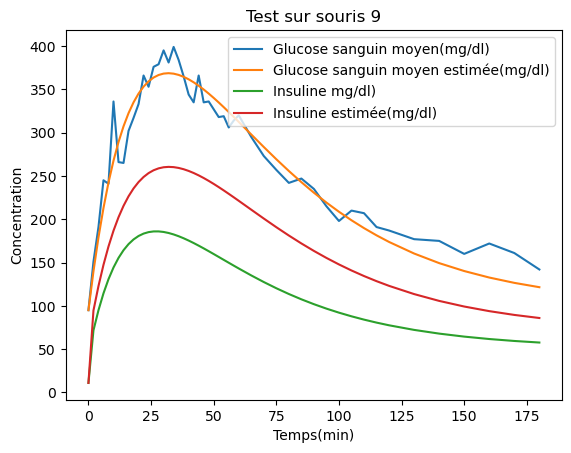

Optimization terminated successfully.
         Current function value: 44445.214855
         Iterations: 114
         Function evaluations: 208
[5.70318757e-03 1.11610570e-10 5.11602046e-02 1.27437226e+00
 8.70020543e+00]


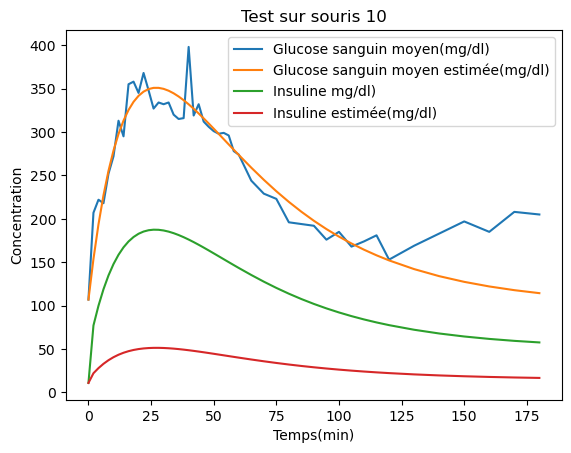

In [18]:
#Ici, on va supposer que k est fixé : la vitesse de sortie

#Ici  on va tester la fixation de k : donc on suppose une vitesse d'absorption initiale identique chez la souris
#Paramètres
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = 1e-2
k = 1e-2
b= 8e-11
c= 0.12
d= 1.5
e= 5.1

para = [U0,b,c,d,e]

def av_model_k_fix(y,t,U0,b,c,d,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    k = params_moy2[1]
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*Gs-e*I
    return dgidt,dgsdt,didt

def distance_av_k_fix(param,obs,t,y0):
    U0,b,c,d,e= param
    P = odeint(av_model_k_fix,y0,t,args=(U0,b,c,d,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(U0<0) + 1e8*(b<0) +1e8*(c<0)+1e8*(d<0) + 1e8*(e<0)


for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av_k_fix,para,args=(data[i],t,y0))
    print(p)
    
    P = odeint(av_model_k_fix,y0,t,args=(params_moy[0],params_moy[2],params_moy[3],params_moy[4],params_moy[5])).T
    Pestim = odeint(av_model_k_fix,y0,t,args=(p[0],p[1],p[2],p[3],p[4])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

Optimization terminated successfully.
         Current function value: 15913.958925
         Iterations: 341
         Function evaluations: 555
[5.80257045e-03 2.33273455e-02 7.05097442e-11 4.04436214e-02
 2.28402223e-02]


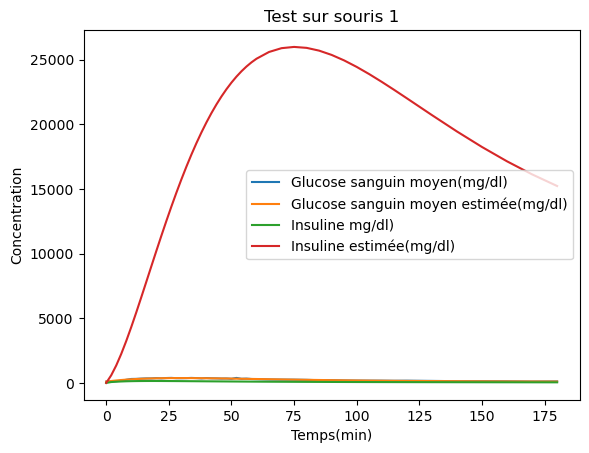

Optimization terminated successfully.
         Current function value: 32015.810882
         Iterations: 249
         Function evaluations: 439
[5.09792821e-03 2.66531775e-02 1.38484049e-12 2.89990256e-02
 1.05379202e+01]


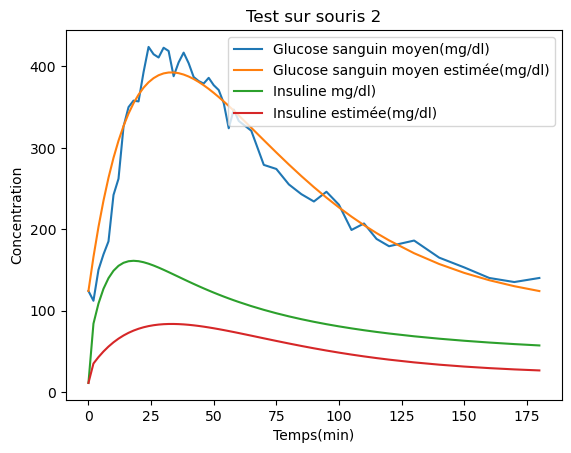

Optimization terminated successfully.
         Current function value: 71775.841683
         Iterations: 141
         Function evaluations: 241
[4.67339299e-03 2.39217390e-02 6.61114411e-12 2.40475302e-02
 8.52580790e+00]


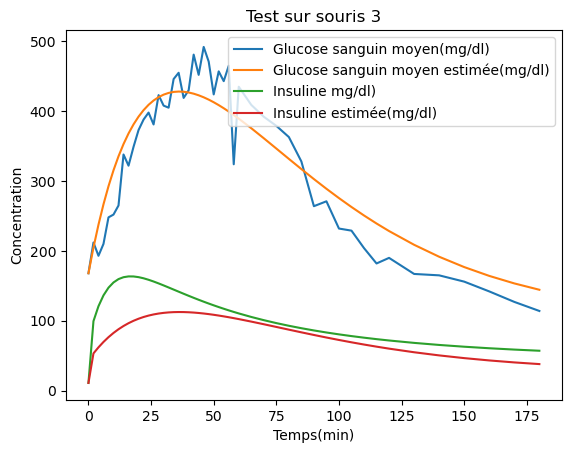

Optimization terminated successfully.
         Current function value: 59131.822843
         Iterations: 257
         Function evaluations: 429
[6.48828220e-03 3.01330999e-02 1.09604158e-10 3.18489112e-02
 1.51628270e-03]


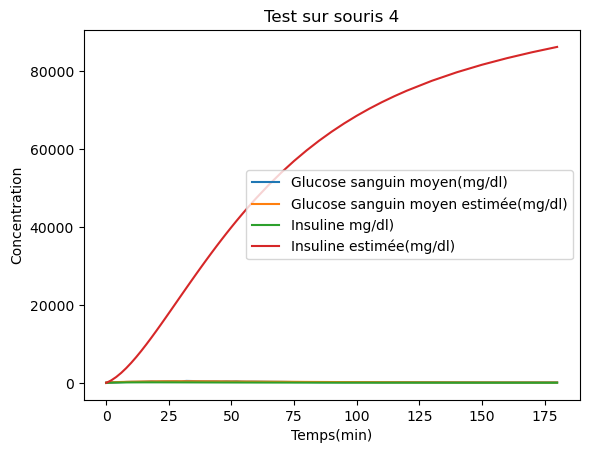

Optimization terminated successfully.
         Current function value: 25707.641568
         Iterations: 170
         Function evaluations: 284
[5.97499999e-03 2.02543130e-02 6.11990571e-11 5.67964858e-02
 6.28556423e+00]


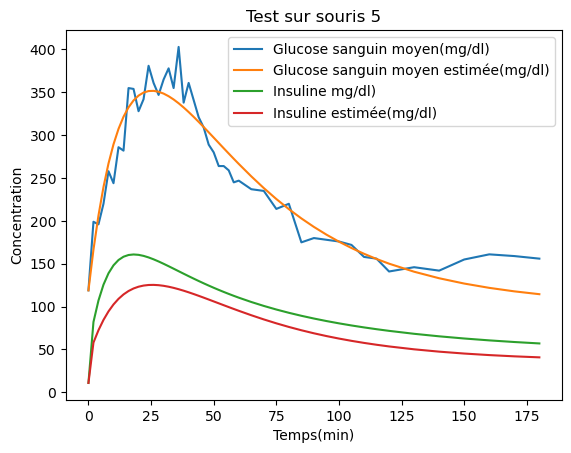

Optimization terminated successfully.
         Current function value: 55615.169788
         Iterations: 164
         Function evaluations: 277
[5.53501591e-03 2.90096933e-02 2.47594521e-11 3.04379125e-02
 6.54900728e-01]


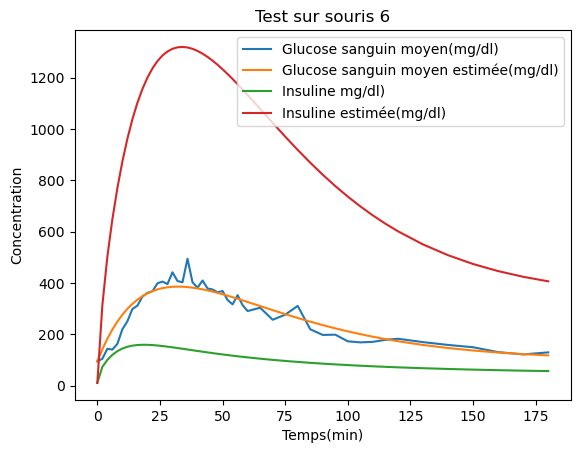

Optimization terminated successfully.
         Current function value: 34892.112998
         Iterations: 306
         Function evaluations: 512
[6.25092886e-03 2.80959268e-02 2.46341894e-11 2.91361951e-02
 1.63722134e+01]


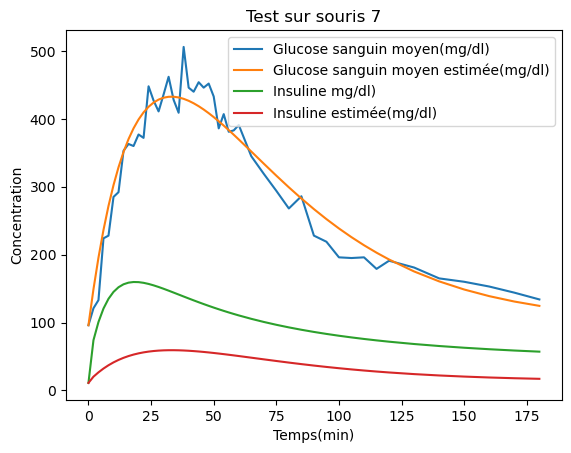

[1.12106463e-02 8.44787451e-03 7.56597588e-11 1.28766106e-01
 5.29703796e+00]


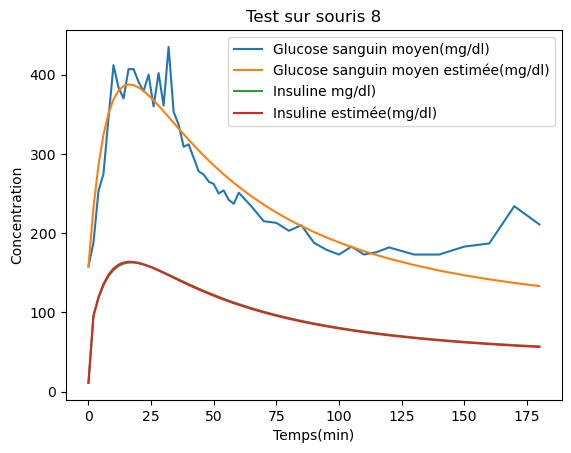

Optimization terminated successfully.
         Current function value: 16032.855853
         Iterations: 146
         Function evaluations: 245
[5.83289078e-03 1.31292309e-02 8.69389611e-11 5.78881557e-02
 8.04377177e+00]


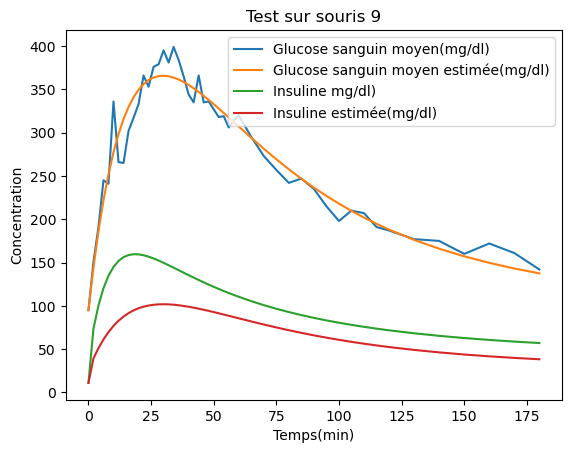

Optimization terminated successfully.
         Current function value: 32412.621937
         Iterations: 251
         Function evaluations: 589
[7.07220684e-03 9.21812911e-03 9.91683854e-11 8.99820579e-02
 6.74358664e+00]


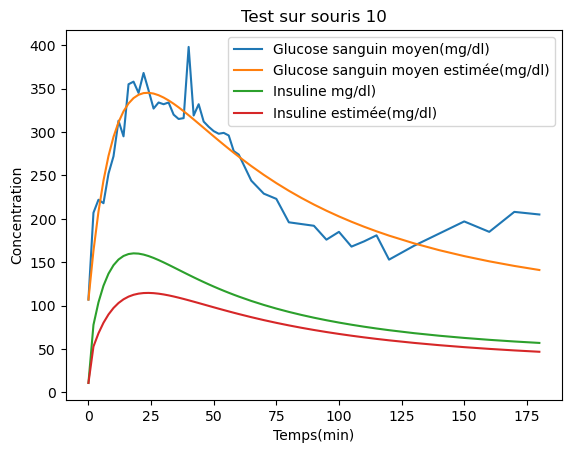

In [19]:
#Ici, on va supposer que d est fixé 

#Ici  on va tester la fixation de d
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = 1e-2
k = 1e-2
b= 8e-11
c= 0.12
d= params_moy2[4]
e= 5.1

para = [U0,k,b,c,e]

def av_model_d_fix(y,t,U0,k,b,c,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    d = params_moy2[4]
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*Gs-e*I
    return dgidt,dgsdt,didt

def distance_av_d_fix(param,obs,t,y0):
    U0,k,b,c,e= param
    P = odeint(av_model_d_fix,y0,t,args=(U0,k,b,c,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(U0<0) + 1e8*(k<0) +1e8*(b<0)+1e8*(c<0) + 1e8*(e<0)


for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av_d_fix,para,args=(data[i],t,y0))
    print(p)
    
    P = odeint(av_model_d_fix,y0,t,args=(U0,k,b,c,e)).T
    Pestim = odeint(av_model_d_fix,y0,t,args=(p[0],p[1],p[2],p[3],p[4])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

Optimization terminated successfully.
         Current function value: 15914.203654
         Iterations: 210
         Function evaluations: 356
[0.00580268 0.02332871 0.04044429 1.33579367 0.1723996 ]


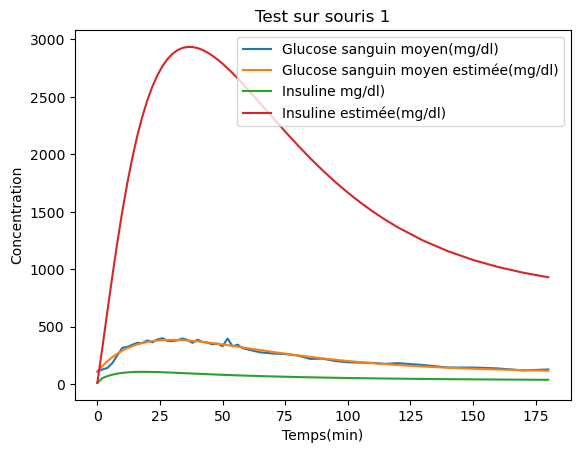

Optimization terminated successfully.
         Current function value: 32015.807679
         Iterations: 252
         Function evaluations: 441
[0.00509792 0.02665363 0.02899856 0.02595938 2.80252982]


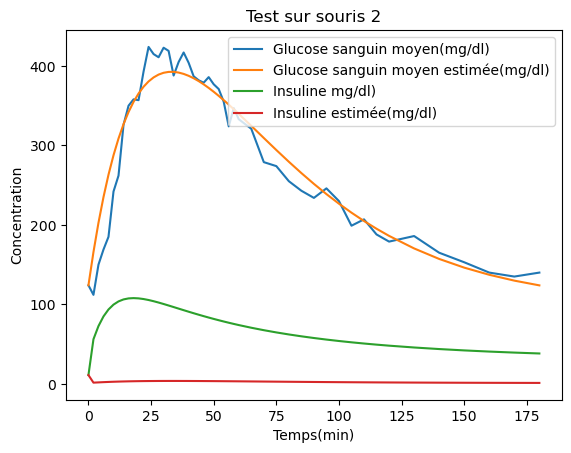

Optimization terminated successfully.
         Current function value: 71775.806156
         Iterations: 164
         Function evaluations: 316
[4.67347265e-03 2.39249081e-02 2.40467549e-02 1.23586750e-01
 6.30189400e+00]


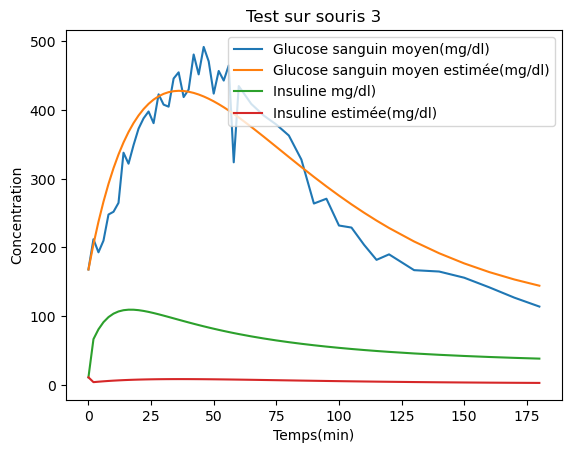

Optimization terminated successfully.
         Current function value: 59138.585970
         Iterations: 238
         Function evaluations: 408
[6.48897082e-03 3.01420571e-02 3.18495410e-02 7.34797688e-03
 6.95359719e+00]


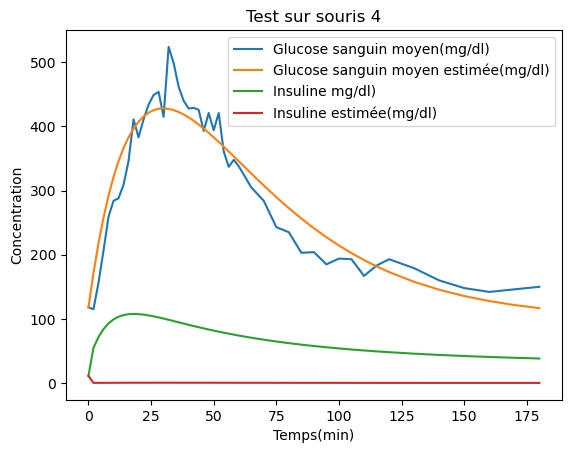

Optimization terminated successfully.
         Current function value: 25707.643955
         Iterations: 138
         Function evaluations: 250
[5.97498258e-03 2.02544044e-02 5.67962456e-02 1.14773856e+00
 6.27941396e+00]


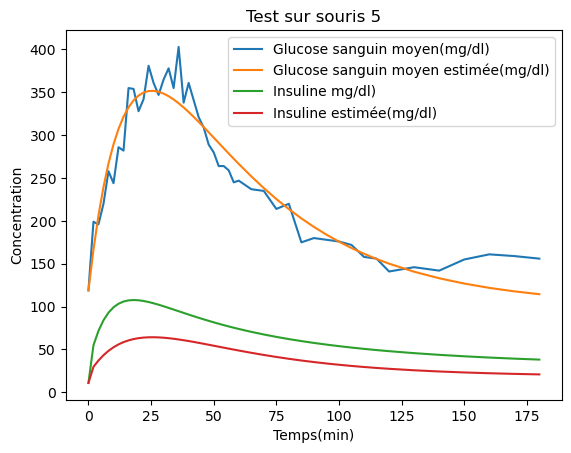

Optimization terminated successfully.
         Current function value: 55615.173370
         Iterations: 177
         Function evaluations: 294
[0.00553499 0.02900804 0.03043938 2.85620257 0.65641388]


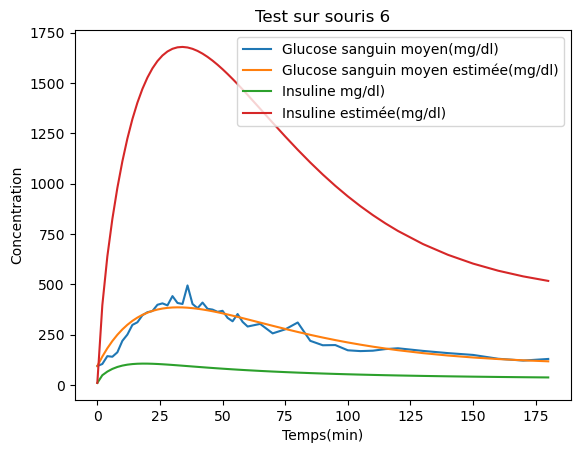

[6.24945797e-03 2.39232290e-02 3.32573976e-02 7.20627490e-03
 1.15340103e-06]


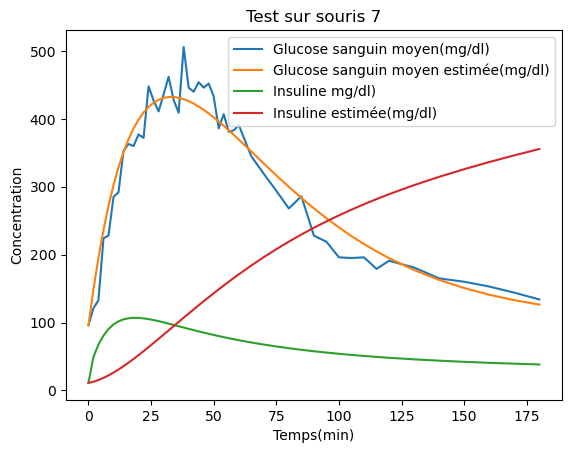

Optimization terminated successfully.
         Current function value: 46064.627812
         Iterations: 102
         Function evaluations: 193
[0.01121084 0.00844871 0.12876197 1.4178076  5.29708865]


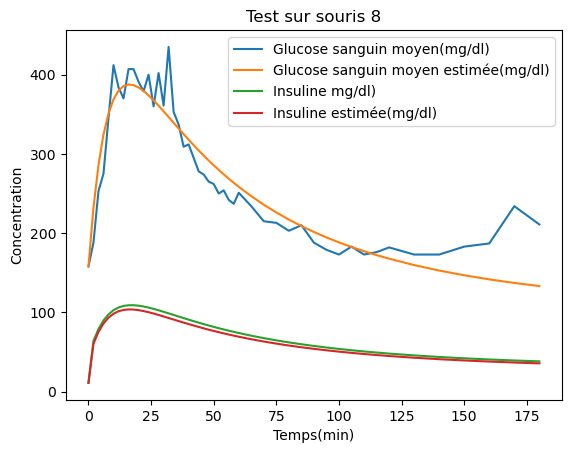

Optimization terminated successfully.
         Current function value: 16032.853229
         Iterations: 147
         Function evaluations: 250
[5.83295407e-03 1.31288560e-02 5.78893971e-02 1.51111264e+00
 8.04387142e+00]


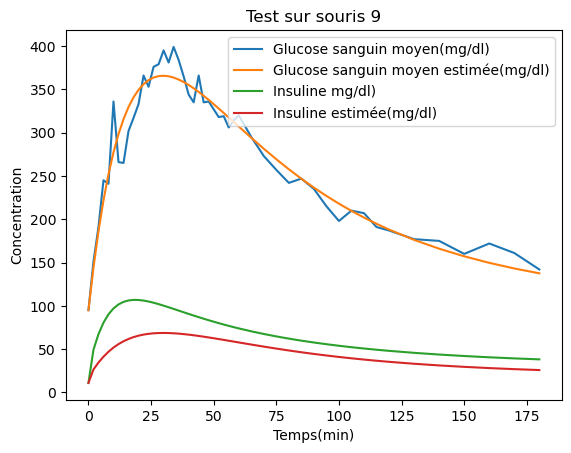

Optimization terminated successfully.
         Current function value: 32412.619515
         Iterations: 115
         Function evaluations: 203
[0.00707211 0.00921827 0.08997974 1.98321564 6.32184989]


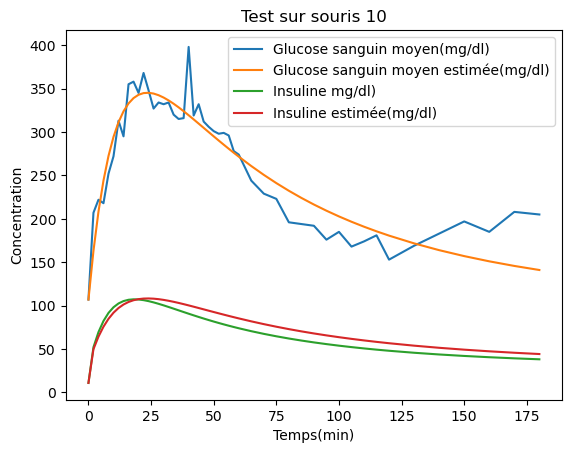

In [20]:
#Ici  on va tester la fixation de b
#dgs**2 pour fixer insuline
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = 1e-2
k = 1e-2
b= params_moy2[2]
c= 0.12
d= 1.5
e= 5.1

para = [U0,k,c,d,e]

def av_model_b_fix(y,t,U0,k,c,d,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    b = params_moy2[2]
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*Gs-e*I
    return dgidt,dgsdt,didt

def distance_av_b_fix(param,obs,t,y0):
    U0,k,c,d,e= param
    P = odeint(av_model_b_fix,y0,t,args=(U0,k,c,d,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(U0<0) + 1e8*(k<0) +1e8*(c<0)+1e8*(d<0) + 1e8*(e<0)


for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av_b_fix,para,args=(data[i],t,y0))
    print(p)
    
    P = odeint(av_model_b_fix,y0,t,args=(U0,k,c,d,e)).T
    Pestim = odeint(av_model_b_fix,y0,t,args=(p[0],p[1],p[2],p[3],p[4])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

Optimization terminated successfully.
         Current function value: 15914.210361
         Iterations: 141
         Function evaluations: 245
[0.00580266 0.02332916 0.04044379 3.62133146]


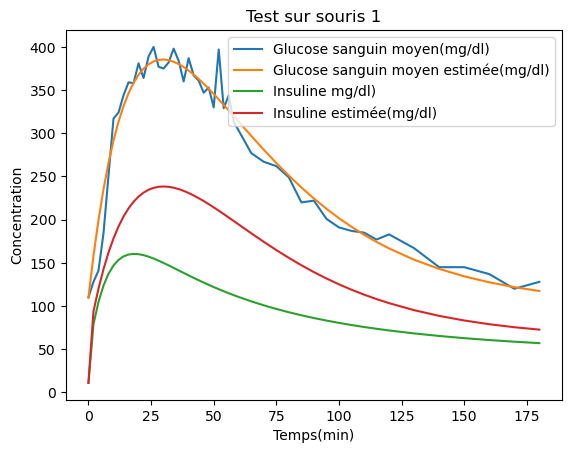

Optimization terminated successfully.
         Current function value: 32015.810760
         Iterations: 154
         Function evaluations: 272
[5.09794831e-03 2.66530951e-02 2.89992862e-02 1.06201783e+01]


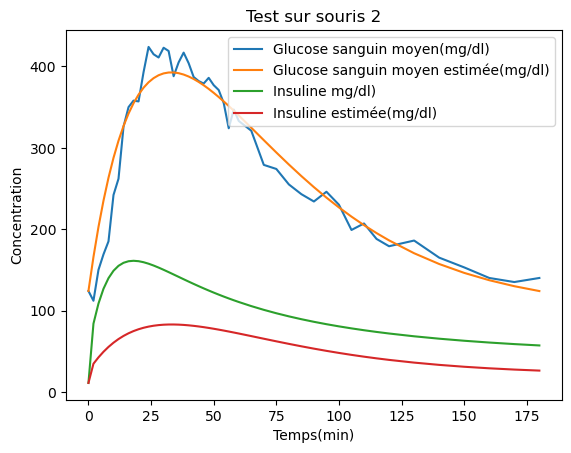

Optimization terminated successfully.
         Current function value: 71775.822761
         Iterations: 152
         Function evaluations: 275
[4.67330531e-03 2.39235907e-02 2.40452084e-02 1.08339146e+01]


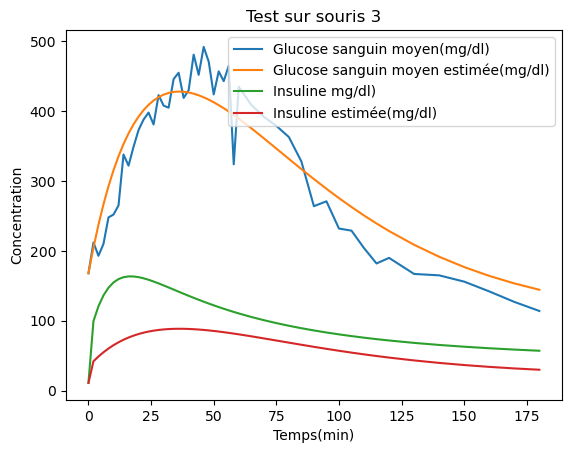

Optimization terminated successfully.
         Current function value: 59138.623830
         Iterations: 138
         Function evaluations: 238
[0.00648894 0.03014177 0.0318496  4.96315532]


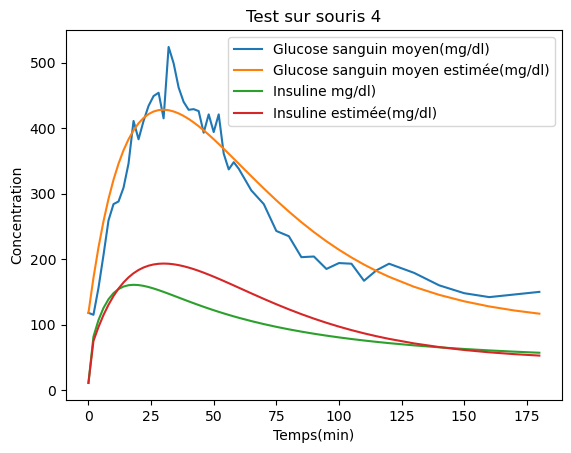

Optimization terminated successfully.
         Current function value: 25707.641724
         Iterations: 130
         Function evaluations: 253
[0.00597497 0.02025443 0.05679569 5.32785377]


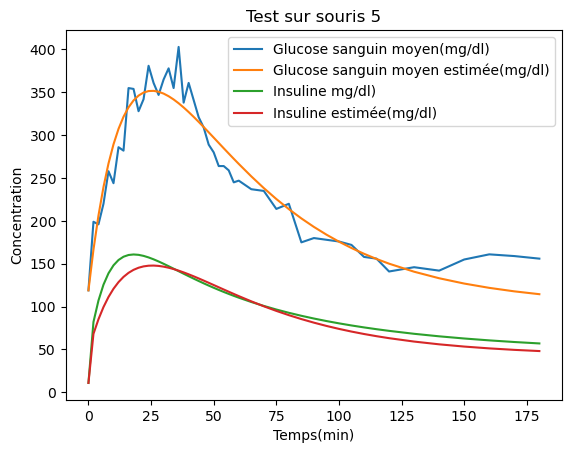

Optimization terminated successfully.
         Current function value: 55615.162843
         Iterations: 244
         Function evaluations: 427
[5.53501489e-03 2.90095570e-02 3.04380449e-02 7.54194392e+00]


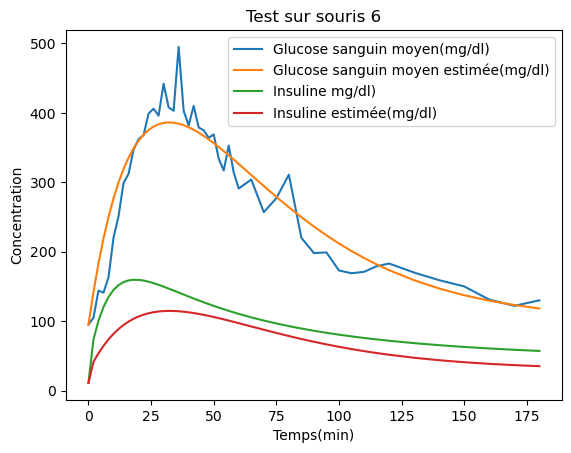

[6.25100580e-03 2.80977314e-02 2.91349038e-02 1.61335086e+01]


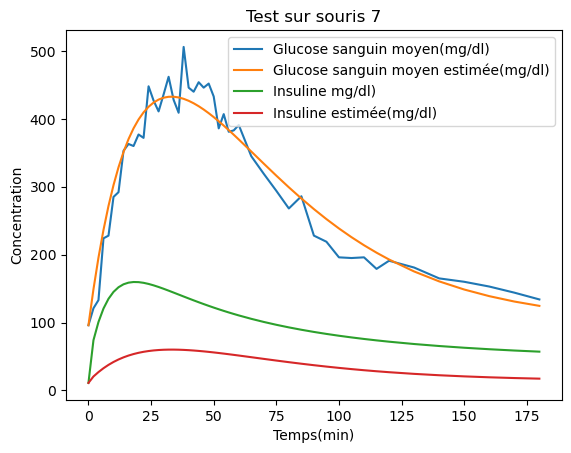

Optimization terminated successfully.
         Current function value: 46064.628075
         Iterations: 95
         Function evaluations: 183
[0.01120984 0.0084498  0.1287512  5.26261092]


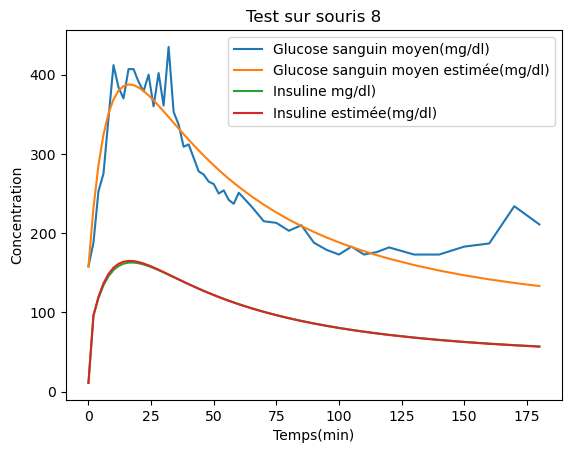

[5.83314168e-03 1.31282562e-02 5.78928034e-02 7.20994296e+00]


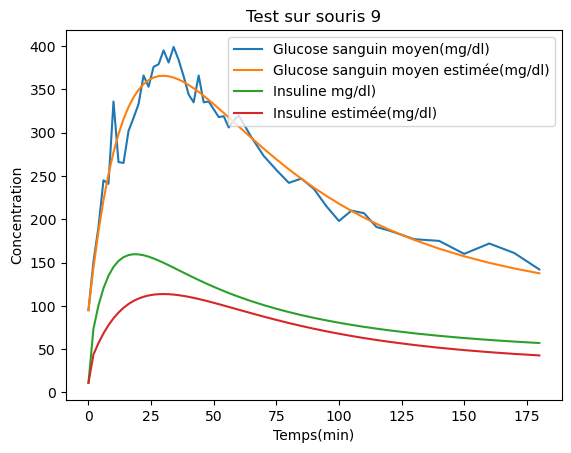

Optimization terminated successfully.
         Current function value: 32412.621586
         Iterations: 112
         Function evaluations: 202
[0.00707215 0.00921836 0.08997961 7.06101612]


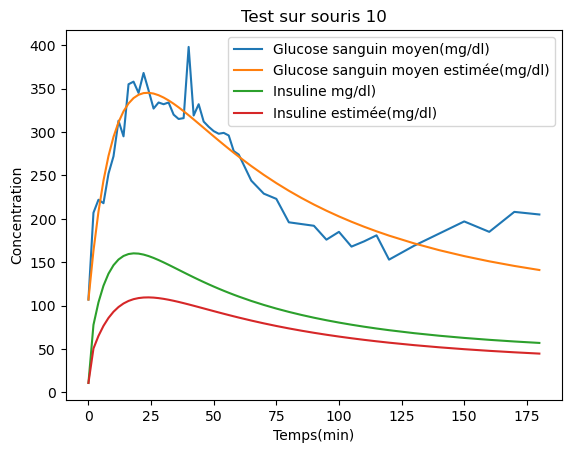

In [21]:
#fixation de b et d

G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = 1e-2
k = 1e-2
b= params_moy2[2]
c= 0.12
d= params_moy2[4]
e= 5.1

para = [U0,k,c,e]

def av_model_db_fix(y,t,U0,k,c,e):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    b = params_moy2[2]
    d = params_moy2[4]
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*Gs-e*I
    return dgidt,dgsdt,didt

def distance_av_db_fix(param,obs,t,y0):
    U0,k,c,e= param
    P = odeint(av_model_db_fix,y0,t,args=(U0,k,c,e,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(U0<0) + 1e8*(k<0) +1e8*(c<0)+ 1e8*(e<0)


for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av_db_fix,para,args=(data[i],t,y0))
    print(p)
    
    P = odeint(av_model_db_fix,y0,t,args=(U0,k,c,e)).T
    Pestim = odeint(av_model_db_fix,y0,t,args=(p[0],p[1],p[2],p[3])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

Optimization terminated successfully.
         Current function value: 15914.210274
         Iterations: 251
         Function evaluations: 563
[0.00580298 0.02332    0.04045719 2.180017  ]


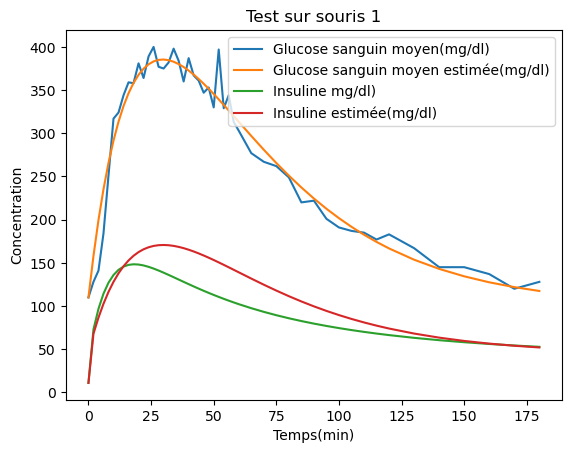

Optimization terminated successfully.
         Current function value: 32015.809009
         Iterations: 146
         Function evaluations: 250
[0.00509794 0.02665368 0.02899859 4.16487284]


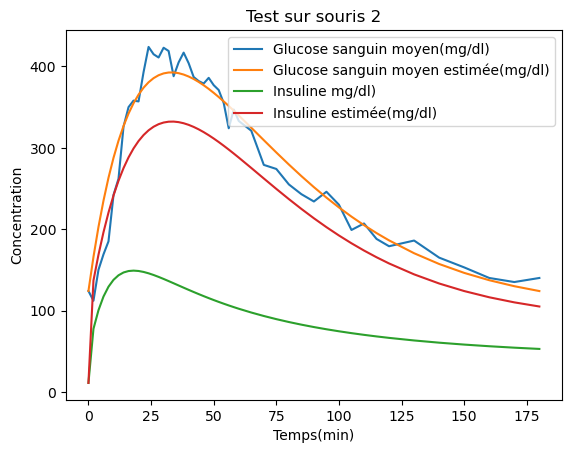

Optimization terminated successfully.
         Current function value: 71775.814456
         Iterations: 329
         Function evaluations: 571
[0.00467335 0.02392132 0.02404757 0.02639036]


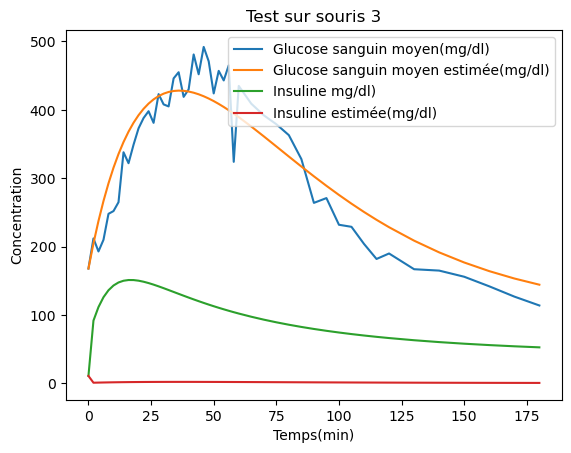

Optimization terminated successfully.
         Current function value: 59138.609557
         Iterations: 149
         Function evaluations: 261
[0.00648928 0.03014574 0.03184802 1.94646587]


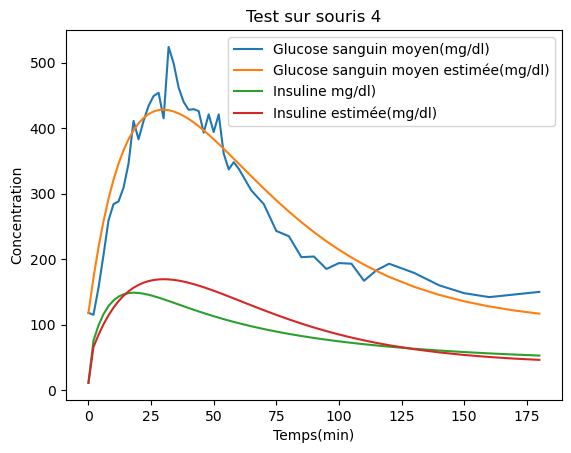

Optimization terminated successfully.
         Current function value: 25707.637488
         Iterations: 219
         Function evaluations: 502
[0.00597497 0.0202554  0.05679371 2.08909306]


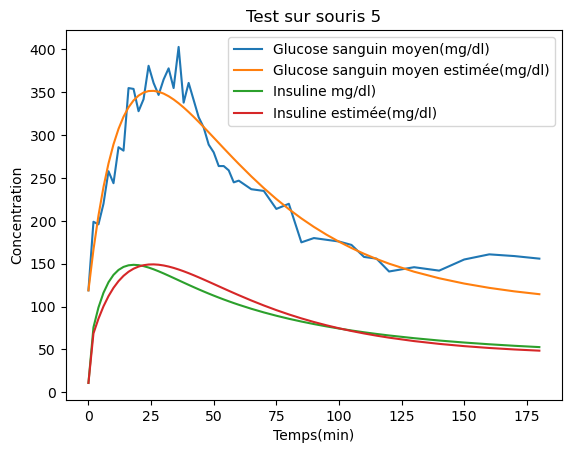

Optimization terminated successfully.
         Current function value: 55615.174457
         Iterations: 210
         Function evaluations: 359
[0.00553497 0.02900815 0.03043896 0.07447838]


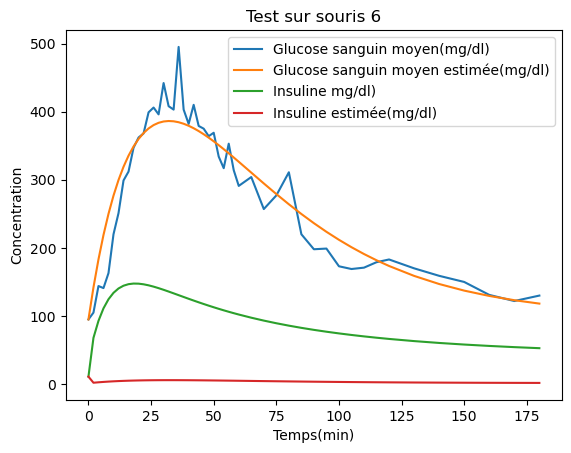

[0.00625108 0.02810244 0.02913051 0.07891979]


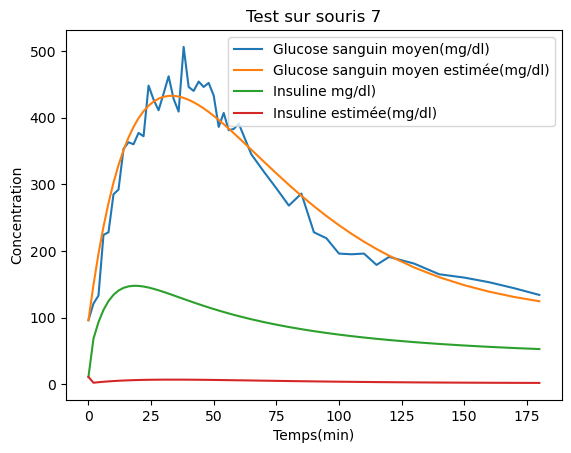

Optimization terminated successfully.
         Current function value: 46064.629481
         Iterations: 78
         Function evaluations: 147
[0.01121024 0.00844952 0.12875455 1.95835866]


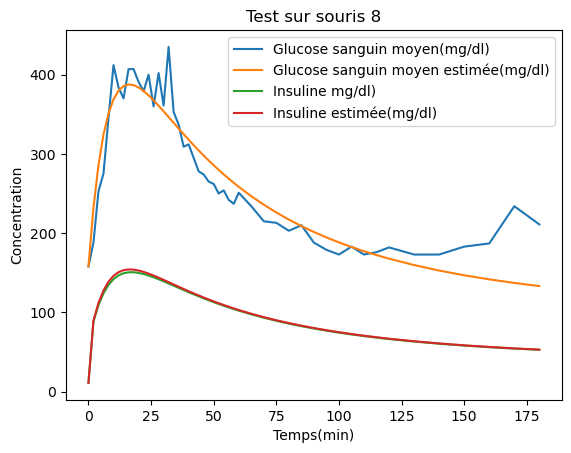

Optimization terminated successfully.
         Current function value: 16032.858070
         Iterations: 90
         Function evaluations: 163
[0.00583291 0.01312907 0.05788873 2.51532534]


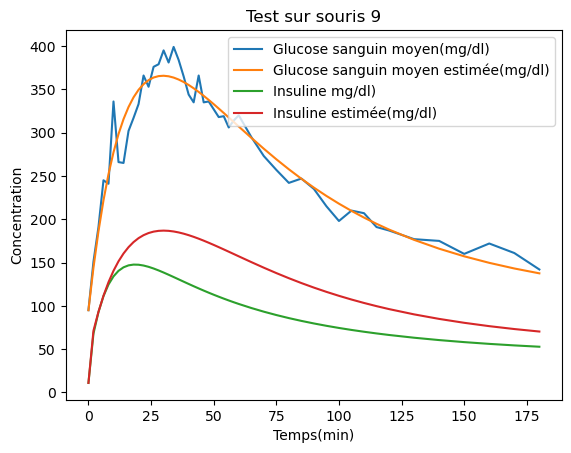

Optimization terminated successfully.
         Current function value: 32412.622088
         Iterations: 98
         Function evaluations: 172
[0.00707209 0.00921827 0.08997964 2.57339277]


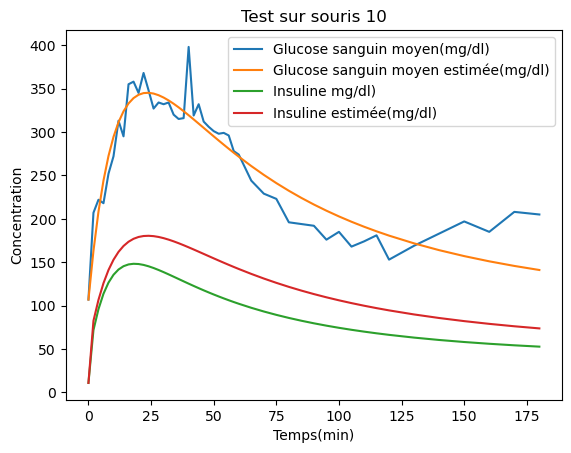

In [22]:
#Ici  on va tester la fixation de b et e
G0 = 4500
y0 = [G0, data[11,0],11]
t = data[0]
a = 0.009
U0 = 1e-2
k = 1e-2
b= params_moy2[2]
c= 0.12
d= 2
e= params_moy2[5]

para = [U0,k,c,d]

def av_model_eb_fix(y,t,U0,k,c,d):
    Gi = y[0]
    Gs = y[1]
    I = y[2]
    Gb = 100
    b = params_moy2[2]
    e = params_moy2[5]
    dgidt = -(U0*np.exp(-k*t))*Gi
    dgsdt = (U0*np.exp(-k*t))*Gi -b*I*Gs - c*max(0,Gs-Gb)
    didt = d*Gs-e*I
    return dgidt,dgsdt,didt

def distance_av_eb_fix(param,obs,t,y0):
    U0,k,c,d= param
    P = odeint(av_model_eb_fix,y0,t,args=(U0,k,c,d,)).T
    su =  np.sum((P[1]-obs)**2)
    return su + 1e8*(U0<0) + 1e8*(k<0) +1e8*(c<0)+1e8*(d<0)


for i in range(1,nbs+1):
    y0 = [G0, data[i,0],11]
    p = fmin(distance_av_eb_fix,para,args=(data[i],t,y0))
    print(p)
    
    P = odeint(av_model_eb_fix,y0,t,args=(U0,k,c,d)).T
    Pestim = odeint(av_model_eb_fix,y0,t,args=(p[0],p[1],p[2],p[3])).T

    plt.plot(t,data[i],label="Glucose sanguin moyen(mg/dl)")
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)")
    plt.plot(t,P[2],label="Insuline mg/dl)")
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

## 4. Modèle pathologique

Nous avons effectué la même expérience - un challenge oral de glucose - a des souris (G0 = 2500 mg/dL) sur deux groupes de souris dont un groupe de souris KO qui sont invalidées pour un gène qui affecte quelque chose en lien avec la tolérance au glucose.  


Pour des raisons de coût (et du fait qu’il y avait d’autres expérimentations) il y a beaucoup moins de points de mesure au cours du temps. Il y a deux fichiers de données un control.txt et un ko.txt. Dans ces fichiers, la première colonne correspond au temps en minute (avec une mesure contrôle à -30), puis dans chaque colonne les mesures de glycémie pour une souris en mg/dL.

(16, 7)
(15, 7)


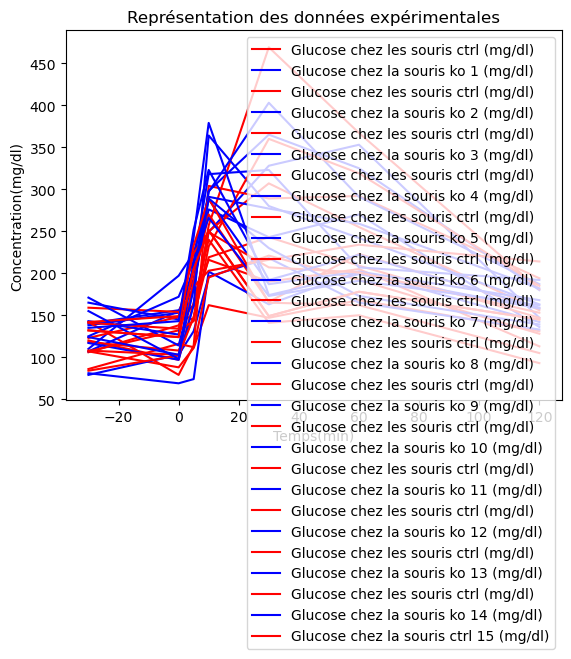

In [24]:
#Chargement des données
datact = np.loadtxt("control.txt",dtype=float).T
datako = np.loadtxt("ko.txt",dtype=float).T
nbs = 15
print(datact.shape)
print(datako.shape)

#Plot 
for i in range(1,nbs):
    plt.plot(datact[0],datact[i],label="Glucose chez les souris ctrl (mg/dl)",color = "r")
    plt.plot(datako[0],datako[i],label="Glucose chez les souris ko (mg/dl)",color = "b")
plt.plot(datact[0],datact[14],label="Glucose chez la souris ctrl "+str(15)+" (mg/dl)",color = "r")

plt.title("Représentation des données expérimentales")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration(mg/dl)')
plt.legend()
plt.show()


En utilisant le modèle développé dans la partie précédente :  
1. trouver les paramètres décrivant les souris des groupes contrôle et KO

In [30]:
datako[0,0]

-30.0

[1.72956308e-03 2.55880104e-03 4.56218192e-02 4.21022801e-07]


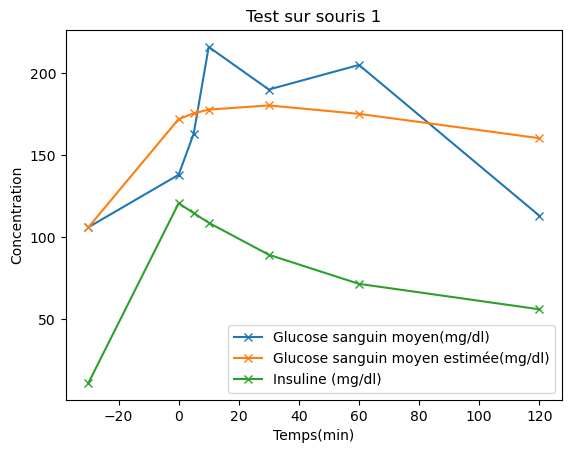

Optimization terminated successfully.
         Current function value: 3612.389835
         Iterations: 205
         Function evaluations: 357
[3.07083643e-04 7.95594311e-03 8.18005296e-03 1.45874501e+01]


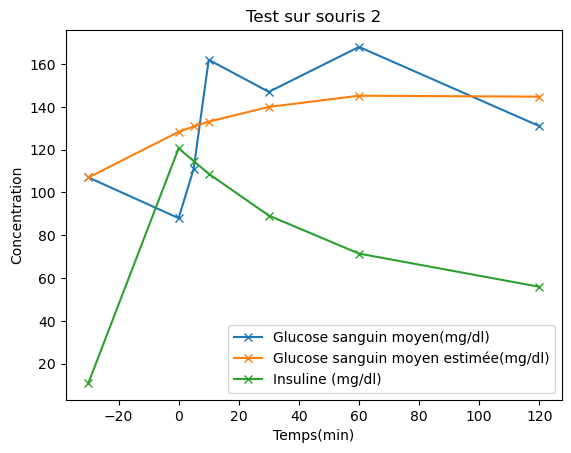

Optimization terminated successfully.
         Current function value: 11157.482325
         Iterations: 200
         Function evaluations: 345
[9.33306402e-04 1.61616591e-02 3.18374923e-02 9.14558661e-07]


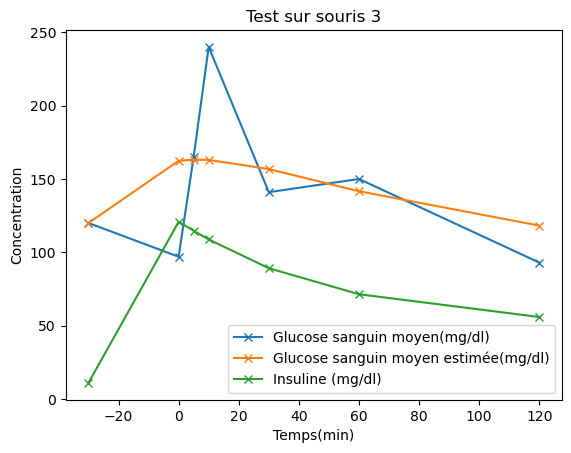

Optimization terminated successfully.
         Current function value: 39318.102720
         Iterations: 190
         Function evaluations: 326
[9.10384752e-04 7.60423127e-03 8.26265784e-03 1.06812304e+01]


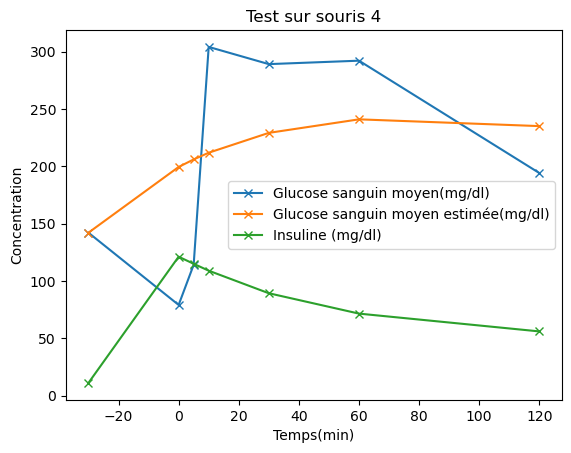

Optimization terminated successfully.
         Current function value: 68044.268008
         Iterations: 167
         Function evaluations: 299
[1.54747255e-03 9.82467211e-03 1.06148864e-02 9.87333826e+00]


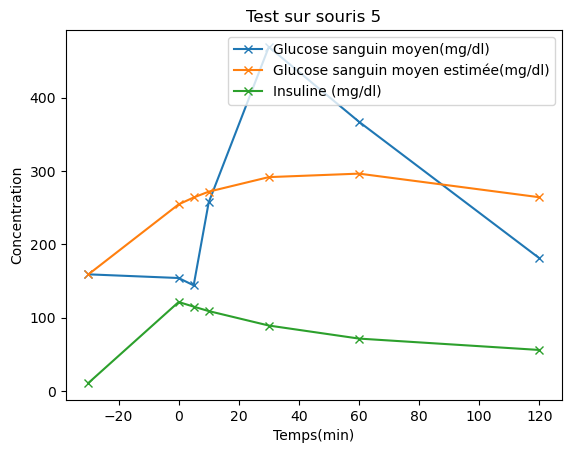

Optimization terminated successfully.
         Current function value: 22190.147540
         Iterations: 264
         Function evaluations: 467
[1.15198642e-03 1.14993618e-02 1.20375931e-02 1.60512377e+01]


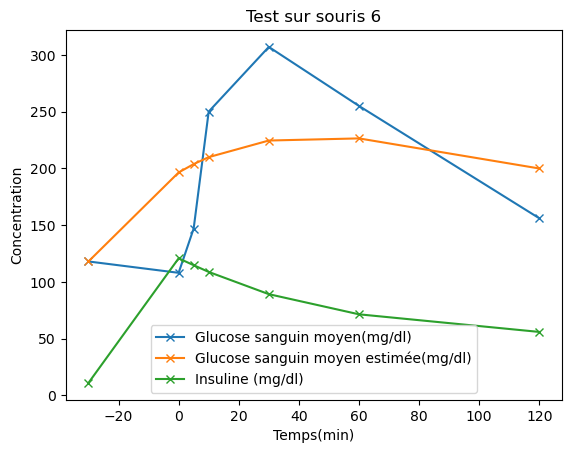

Optimization terminated successfully.
         Current function value: 11661.568567
         Iterations: 342
         Function evaluations: 601
[3.90350448e-03 1.57006771e-10 1.32096780e-01 5.26078547e-03]


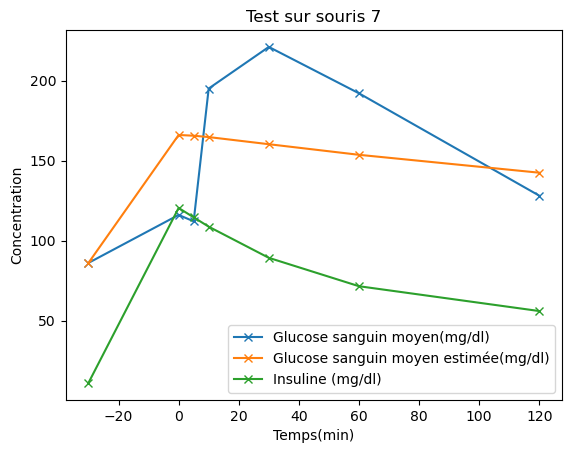

Optimization terminated successfully.
         Current function value: 9448.417502
         Iterations: 159
         Function evaluations: 289
[1.07733920e-03 1.29379565e-02 1.36913599e-02 9.10595997e+00]


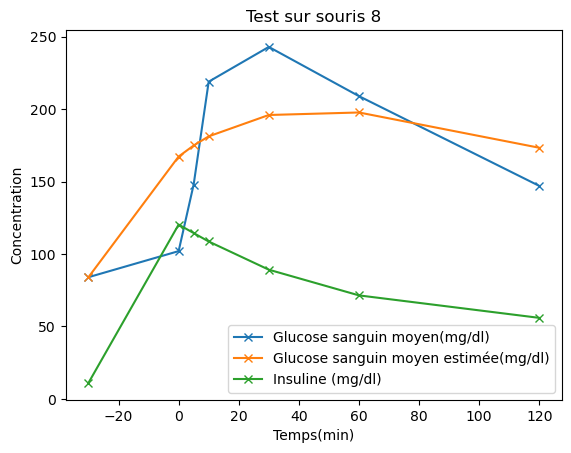

Optimization terminated successfully.
         Current function value: 29561.028831
         Iterations: 182
         Function evaluations: 327
[1.44711630e-03 9.85361089e-03 1.07752837e-02 7.35480959e+00]


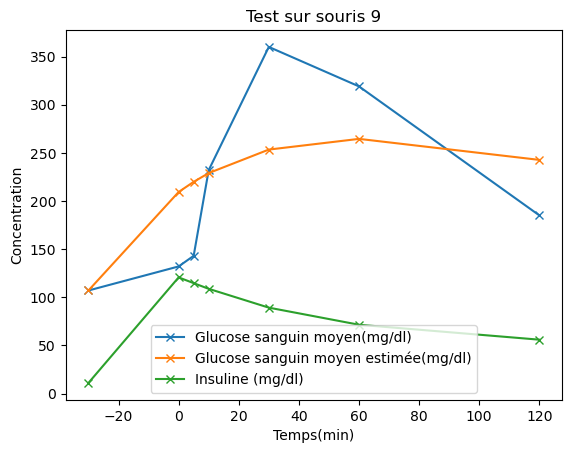

Optimization terminated successfully.
         Current function value: 14257.249609
         Iterations: 255
         Function evaluations: 453
[1.19817524e-03 7.81647466e-03 1.99048205e-02 1.37617581e-06]


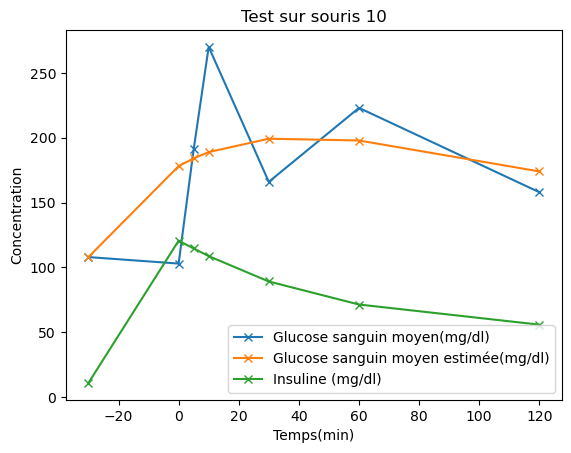

Optimization terminated successfully.
         Current function value: 1316.992824
         Iterations: 199
         Function evaluations: 357
[8.27609217e-04 7.41385282e-03 8.07797903e-03 2.26812130e+01]


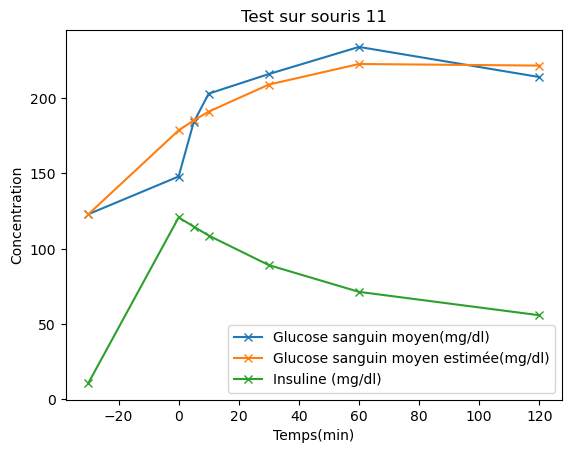

Optimization terminated successfully.
         Current function value: 4849.862362
         Iterations: 168
         Function evaluations: 289
[1.06141232e-03 1.56910670e-02 1.58778927e-02 1.32199305e+01]


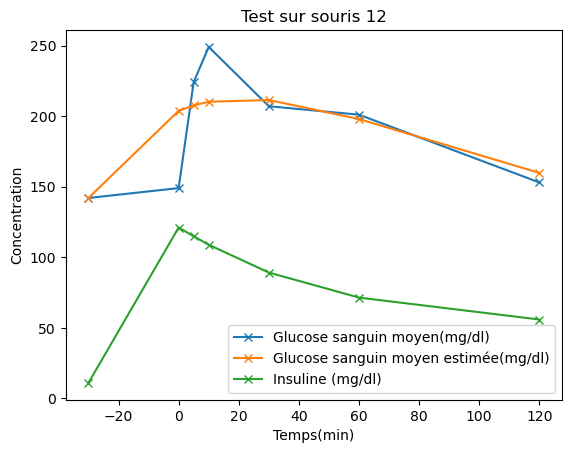

Optimization terminated successfully.
         Current function value: 13832.375516
         Iterations: 149
         Function evaluations: 261
[1.28729095e-03 2.66855826e-02 2.64478531e-02 1.20348286e+01]


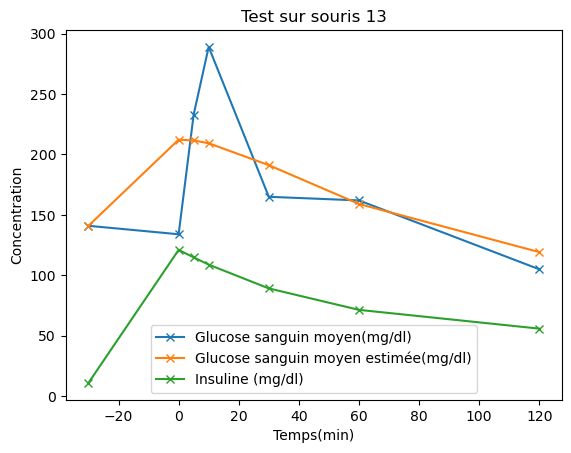

Optimization terminated successfully.
         Current function value: 9324.323262
         Iterations: 237
         Function evaluations: 415
[1.17842233e-03 1.01747127e-02 2.69029383e-02 2.65453312e+00]


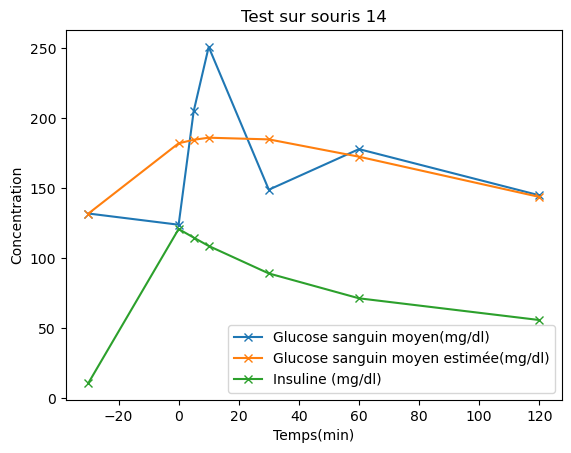

Optimization terminated successfully.
         Current function value: 13253.170008
         Iterations: 183
         Function evaluations: 321
[1.25898276e-03 1.97827799e-02 2.00626786e-02 1.84731588e+01]


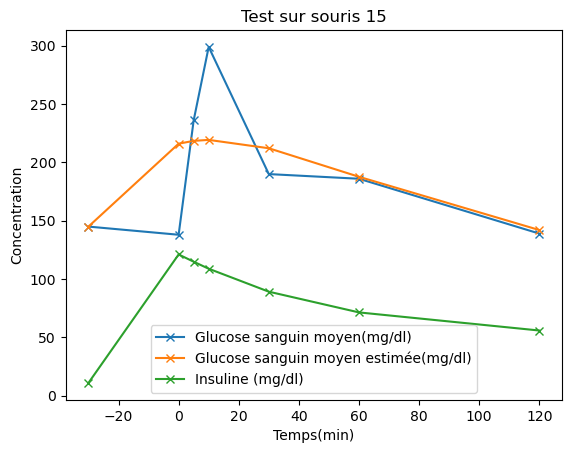

In [92]:
#tester plus tard avec be
#Test u0 et k


G0 = 2500
y0 = [G0, datact[1,0],11]
t = data[0]
a = 0.009
U0 = 1e-2
k = 1e-2
b= params_moy2[2]
c= 0.12
d= params_moy2[4]
e= 5

#av_model_db_fix : eq
#distance__av_db_fix : distance
para = [U0,k,c,e]
t = datact[0]

arrayct = np.zeros((15,4))

for i in range(1,16):
    y0 = [G0, datact[i,0],11]
    p = fmin(distance_av_db_fix,para,args=(datact[i],t,y0))
    print(p)
    
    arrayct[i-1] = p 
    
    P = odeint(av_model_db_fix,y0,t,args=(U0,k,c,e)).T
    Pestim = odeint(av_model_db_fix,y0,t,args=(p[0],p[1],p[2],p[3])).T

    plt.plot(t,datact[i],label="Glucose sanguin moyen(mg/dl)",marker='x')
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)",marker='x')
    plt.plot(t,P[2],label="Insuline (mg/dl)",marker='x')
    #plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)")


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris "+str(i))
    plt.legend()
    plt.show()

Optimization terminated successfully.
         Current function value: 53298.554249
         Iterations: 360
         Function evaluations: 650
[8.11800747e-03 8.76537457e-12 1.17151145e-01 7.59493290e-08]


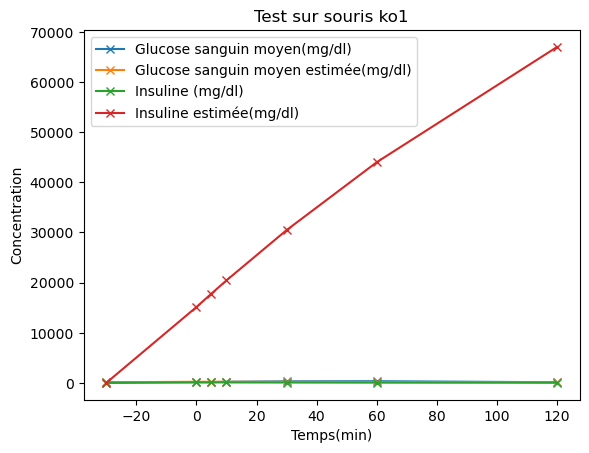

Optimization terminated successfully.
         Current function value: 11861.385347
         Iterations: 145
         Function evaluations: 256
[1.24319553e-03 1.43391951e-02 1.45096340e-02 1.06950424e+01]


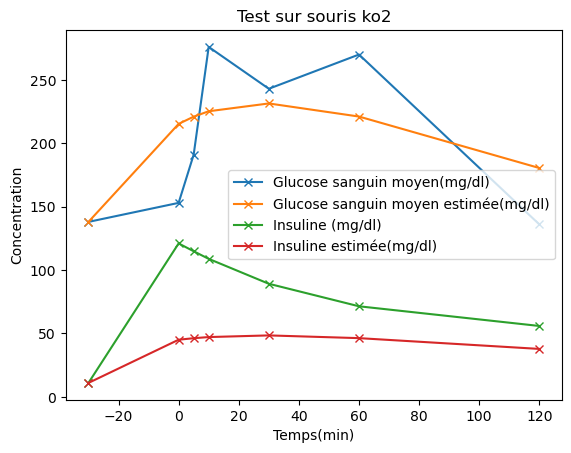

Optimization terminated successfully.
         Current function value: 6483.408657
         Iterations: 226
         Function evaluations: 385
[8.89878413e-04 1.45295101e-02 1.55462409e-02 9.91778848e+00]


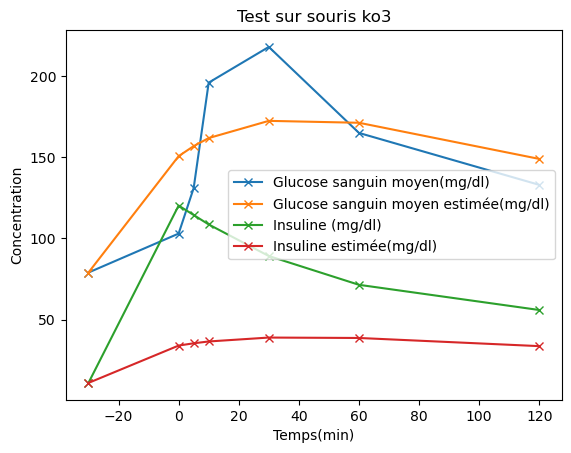

Optimization terminated successfully.
         Current function value: 23796.059644
         Iterations: 159
         Function evaluations: 296
[1.89727924e-03 1.22452181e-02 1.31131168e-02 2.14083274e+01]


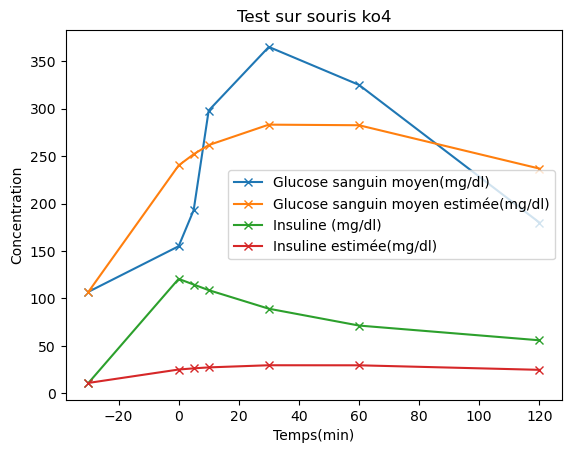

Optimization terminated successfully.
         Current function value: 13035.022627
         Iterations: 166
         Function evaluations: 312
[5.70249959e-04 7.80658270e-03 9.55971637e-03 4.97890894e+00]


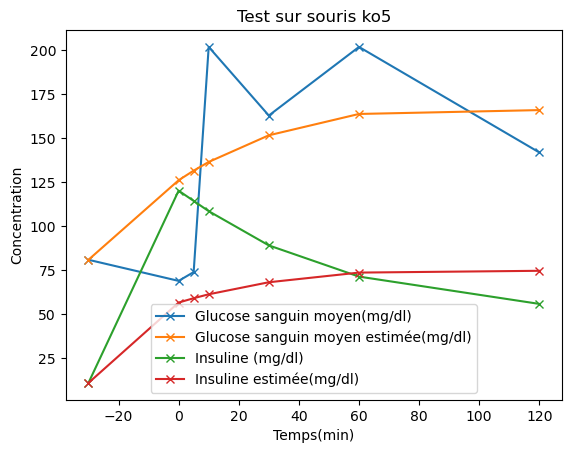

Optimization terminated successfully.
         Current function value: 38317.121859
         Iterations: 198
         Function evaluations: 344
[1.44353782e-03 1.36614246e-02 1.42369141e-02 2.55991223e+01]


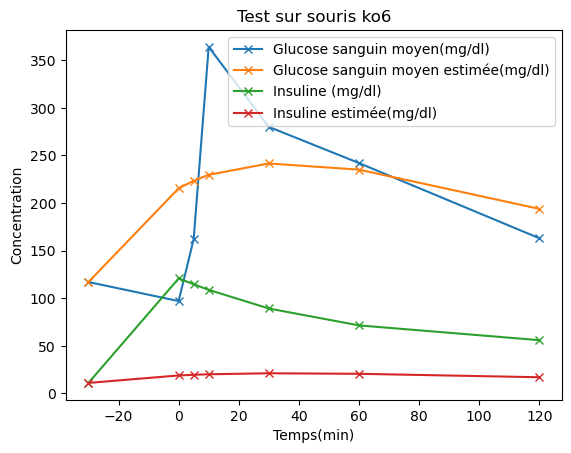

Optimization terminated successfully.
         Current function value: 3936.727200
         Iterations: 148
         Function evaluations: 282
[1.79149054e-03 1.48479700e-02 1.53942042e-02 3.64040505e+00]


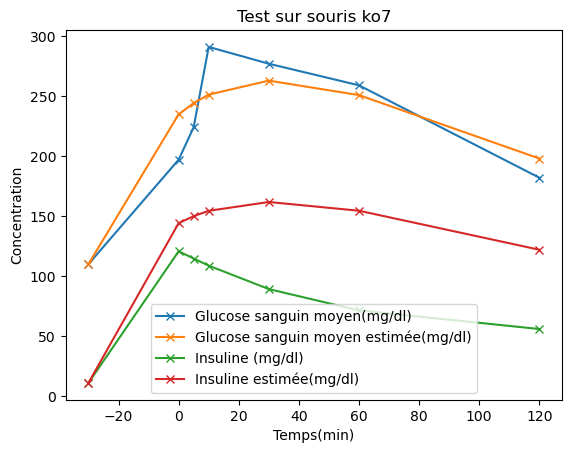

Optimization terminated successfully.
         Current function value: 43923.298080
         Iterations: 197
         Function evaluations: 343
[1.27715574e-03 1.03011407e-02 1.08451093e-02 1.68004666e+01]


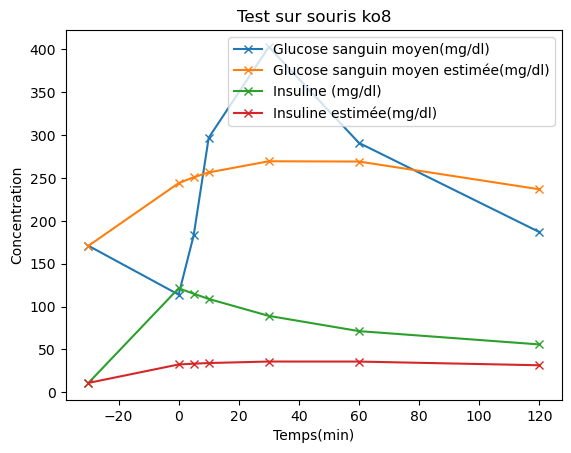

Optimization terminated successfully.
         Current function value: 15173.196309
         Iterations: 230
         Function evaluations: 392
[0.00172907 0.01483371 0.01582254 0.60166603]


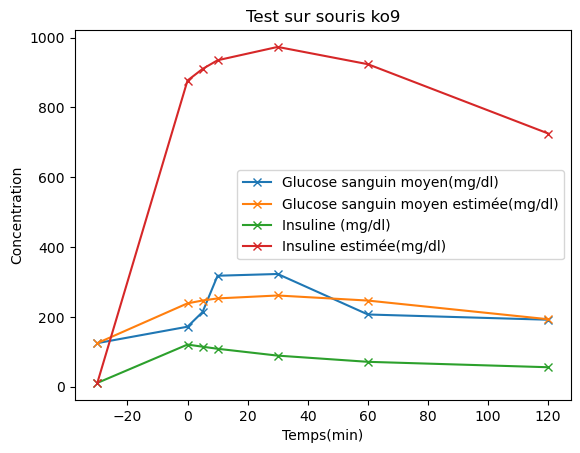

Optimization terminated successfully.
         Current function value: 10320.737450
         Iterations: 206
         Function evaluations: 360
[8.52539077e-04 1.31785505e-02 1.36598753e-02 1.28081617e+01]


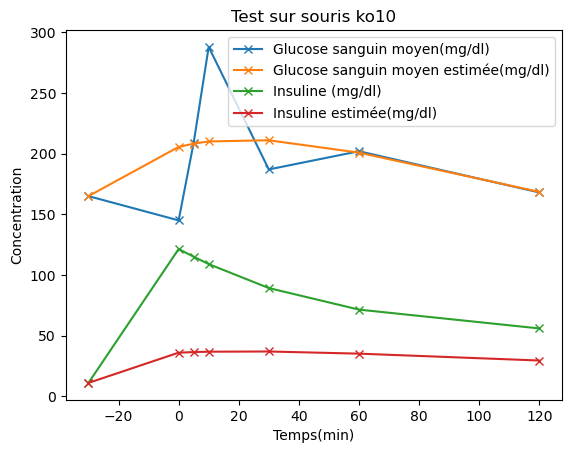

Optimization terminated successfully.
         Current function value: 34485.299306
         Iterations: 258
         Function evaluations: 443
[0.00173545 0.01551194 0.02420516 0.72594623]


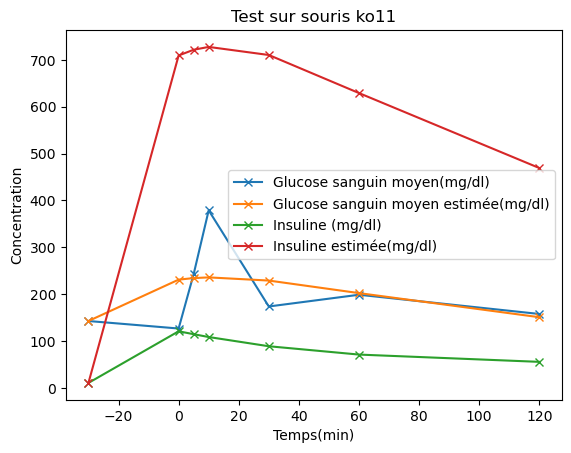

Optimization terminated successfully.
         Current function value: 14565.077079
         Iterations: 236
         Function evaluations: 409
[8.13779857e-04 8.14646869e-03 1.65995191e-02 1.10183977e-06]


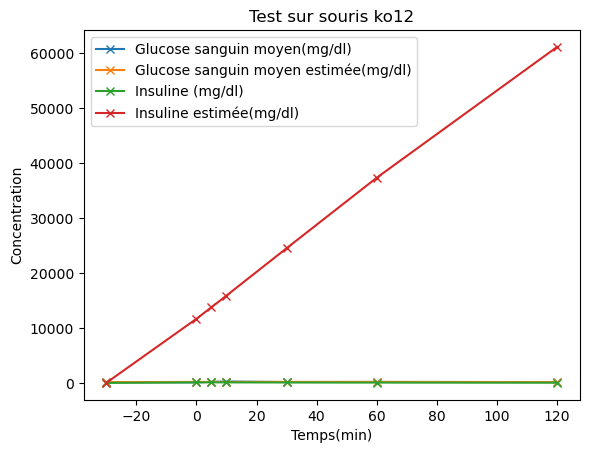

Optimization terminated successfully.
         Current function value: 17056.561713
         Iterations: 167
         Function evaluations: 283
[1.45508851e-03 1.71882311e-02 1.78534580e-02 8.35639338e+00]


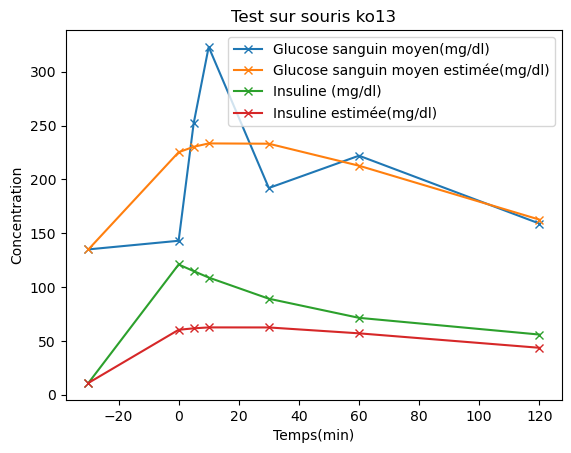

Optimization terminated successfully.
         Current function value: 17446.791065
         Iterations: 315
         Function evaluations: 539
[0.00108014 0.01678484 0.01705398 0.40082787]


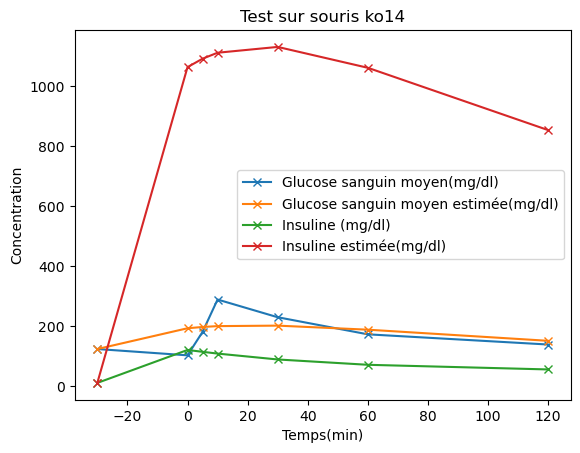

In [93]:
t = datako[0]
arrayko = np.zeros((14,4))
tt = np.linspace(0,150,100)

for i in range(1,15):
    y0 = [G0, datako[i,0],11]
    p = fmin(distance_av_db_fix,para,args=(datako[i],t,y0))
    print(p)
    
    arrayko[i-1] = p
    
    P = odeint(av_model_db_fix,y0,t,args=(U0,k,c,e)).T
    Pestim = odeint(av_model_db_fix,y0,t,args=(p[0],p[1],p[2],p[3])).T

    plt.plot(t,datako[i],label="Glucose sanguin moyen(mg/dl)",marker='x')
    plt.plot(t,Pestim[1],label="Glucose sanguin moyen estimée(mg/dl)",marker='x')
    plt.plot(t,P[2],label="Insuline (mg/dl)",marker='x')
    plt.plot(t,Pestim[2],label="Insuline estimée(mg/dl)",marker='x')


    plt.xlabel('Temps(min)')
    plt.ylabel('Concentration')
    plt.title("Test sur souris ko"+str(i))
    plt.legend()
    plt.show()

In [84]:
arrayct_tr

array([[1.50155129e-03, 3.07084967e-04, 8.03143473e-04, 9.10364144e-04,
        1.54745963e-03, 1.15188483e-03, 8.58219354e-04, 1.07732274e-03,
        1.44717961e-03, 1.19823862e-03, 8.27597561e-04, 1.06141181e-03,
        1.44937697e-03, 1.17842296e-03, 1.25898322e-03],
       [4.68416547e-03, 7.95588426e-03, 1.96005082e-02, 7.60370762e-03,
        9.82330823e-03, 1.15002420e-02, 1.34910443e-02, 1.29401475e-02,
        9.85167686e-03, 7.81646157e-03, 7.41433021e-03, 1.56910105e-02,
        2.31201306e-02, 1.01748829e-02, 1.97827517e-02],
       [3.68453695e-02, 8.18013640e-03, 2.67207807e-02, 8.26224452e-03,
        1.06150479e-02, 1.20353626e-02, 1.40926939e-02, 1.36897232e-02,
        1.07769559e-02, 1.99083127e-02, 8.07757074e-03, 1.58779861e-02,
        2.99315909e-02, 2.69029277e-02, 2.00626897e-02],
       [6.48082484e-07, 1.48792754e+01, 3.52182398e-08, 1.01665990e+01,
        1.00711355e+01, 1.63724029e+01, 3.21043466e+01, 9.28761552e+00,
        7.50261365e+00, 3.62184647e-0

In [101]:
arrayct_tr = arrayct.T
arrayko_tr = arrayko.T

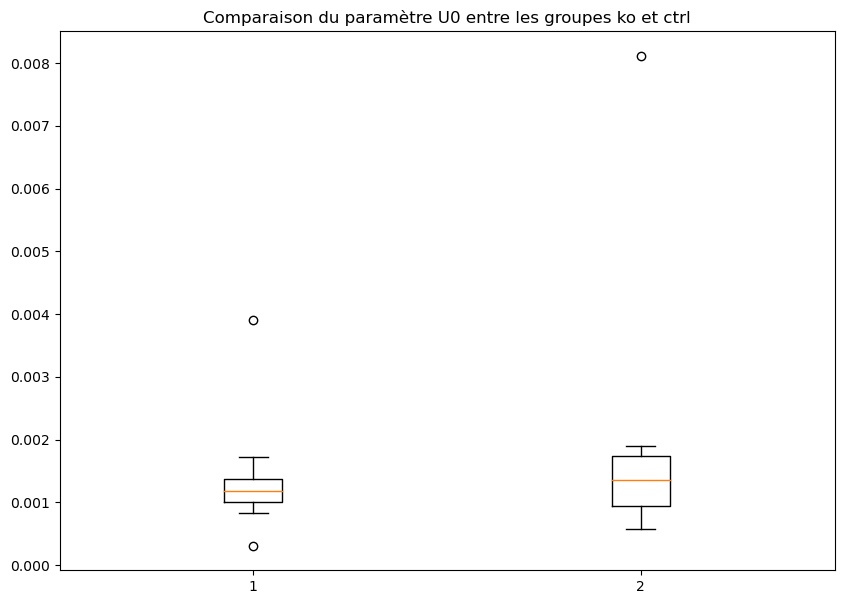

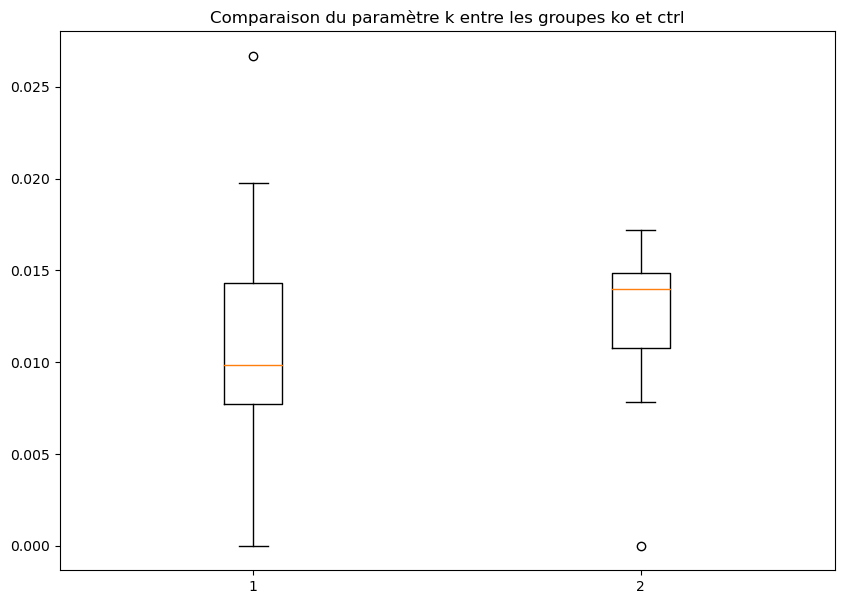

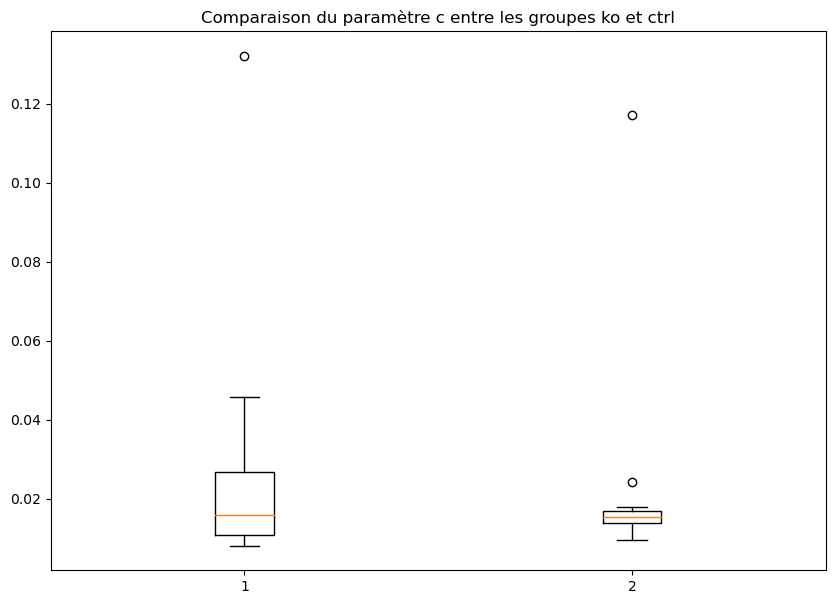

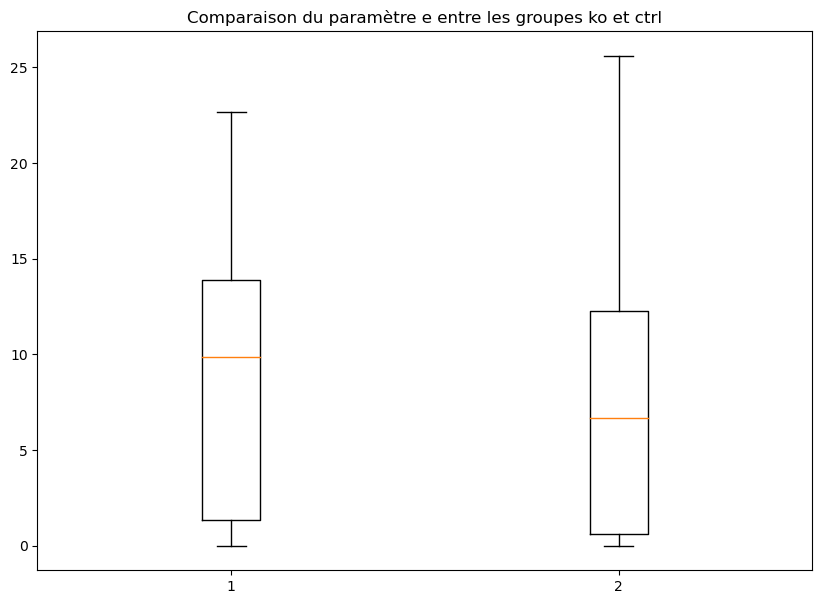

In [103]:
lp = ['U0','k','c','e']
for i in range(4):
    fig = plt.figure(figsize =(10, 7))
    plt.boxplot([arrayct_tr[i],arrayko_tr[i]])
    plt.title("Comparaison du paramètre "+lp[i]+" entre les groupes ko et ctrl")
    plt.show()

In [99]:
test_u0 = ttest_ind(arrayct_tr[0],arrayko_tr[0],equal_var=False)
test_k = ttest_ind(arrayct_tr[1],arrayko_tr[1],equal_var=False)
test_c = ttest_ind(arrayct_tr[2],arrayko_tr[2],equal_var=False)
test_e = ttest_ind(arrayct_tr[3],arrayko_tr[3],equal_var=False)

print(test_u0)
print(test_k)
print(test_c)
print(test_e)

Ttest_indResult(statistic=-0.8467829981733116, pvalue=0.40872896992937524)
Ttest_indResult(statistic=-0.6276600792264755, pvalue=0.5359340331674016)
Ttest_indResult(statistic=0.3200884337257978, pvalue=0.7513729550604837)
Ttest_indResult(statistic=0.28338878984264165, pvalue=0.7791322396379398)


2. discuter de la pertinence de ces paramètres au vu du nombre de points de données


En vue du nombre de points par souris, je n'arrive pas a observer des paramètres qui se distingueraient entre les groupes KO et ct.  

3. en déduire un impact (ou pas) physiologique du KO


Pour cette partie, il faudra donner les paramètres efficaces souris par souris et faire une comparaison (avec des tests stats ?) entre les deux groupes et donner une conclusion biologique. On entend par la d’où vient la différence exprimée en terme physiologique.
